refference 
https://entreprenerdly.com/top-36-moving-averages-methods-for-stock-prices-in-python/
Top 36 Moving Averages Methods For Stock Prices In Python

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np

In [49]:
dataset = yf.download('NDX', start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'),
                      progress=False,
                      period="ytd", interval="1d")
dataset = dataset.reset_index()
dataset['Date'] = pd.to_datetime(dataset['Date'])
dataset

Date          Open          High           Low         Close  \
0    2020-02-11   9517.860352   9517.860352   9517.860352   9517.860352   
1    2020-02-12   9613.200195   9613.200195   9613.200195   9613.200195   
2    2020-02-13   9595.700195   9595.700195   9595.700195   9595.700195   
3    2020-02-14   9623.580078   9623.580078   9623.580078   9623.580078   
4    2020-02-18   9629.799805   9629.799805   9629.799805   9629.799805   
...         ...           ...           ...           ...           ...   
1064 2024-07-18  19705.089844  19705.089844  19705.089844  19705.089844   
1065 2024-07-19  19522.619141  19522.619141  19522.619141  19522.619141   
1066 2024-07-22  19822.869141  19822.869141  19822.869141  19822.869141   
1067 2024-07-23  19754.339844  19754.339844  19754.339844  19754.339844   
1068 2024-07-24  19032.390625  19032.390625  19032.390625  19032.390625   

         Adj Close  Volume  
0      9517.860352       0  
1      9613.200195       0  
2      9595.700195       0  
3      9623.580078       0  
4      9629.799805       0  
...            ...     ...  
1064  19705.089844       0  
1065  19522.619141       0  
1066  19822.869141       0  
1067  19754.339844       0  
1068  19032.390625       0  

[1069 rows x 7 columns]

In [50]:
# Fractal Adaptive Moving Average (FRAMA)
def fetch_data(ticker_symbol, start_date, end_date):
    data = yf.download(ticker_symbol, start=start_date, end=end_date)
    return data


def calculate_FRAMA(data, batch=10):
    # Input
    InputPrice = data['Close'].values

    Length = len(InputPrice)
    Filt = np.array(InputPrice)

    # Sequentially calculate all variables and the output
    for i in range(2 * batch, Length):

        # Take 2 batches of the input
        v1 = InputPrice[i-2*batch:i - batch]
        v2 = InputPrice[i - batch:i]

        # For the 1st batch calculate N1
        H1 = np.max(v1)
        L1 = np.min(v1)
        N1 = (H1 - L1) / batch

        # For the 2nd batch calculate N2
        H2 = np.max(v2)
        L2 = np.min(v2)
        N2 = (H2 - L2) / batch

        # For both batches calculate N3
        H = np.max([H1, H2])
        L = np.min([L1, L2])
        N3 = (H - L) / (2 * batch)

        # Calculate fractal dimension
        Dimen = 0
        if N1 > 0 and N2 > 0 and N3 > 0:
            Dimen = (np.log(N1 + N2) - np.log(N3)) / np.log(2)

        # Calculate lowpass filter factor
        alpha = np.exp(-4.6 * (Dimen) - 1)
        # Ensuring alpha stays between 0.1 and 1
        alpha = np.clip(alpha, 0.1, 1)

        # Filter the input data
        Filt[i] = alpha * InputPrice[i] + (1 - alpha) * Filt[i-1]

    data['FRAMA'] = Filt
    return data


dataset = calculate_FRAMA(dataset)

# Zero Lag Exponential Moving Average (ZLEMA)


def calculate_EMA(prices, period):
    alpha = 2 / (period + 1)
    EMA = [prices[0]]
    for price in prices[1:]:
        EMA.append((price - EMA[-1]) * alpha + EMA[-1])
    return EMA


def calculate_ZLEMA(prices, period):
    prices = pd.Series(prices)  # Ensure prices is a pandas Series
    lag = period // 2
    adjusted_prices = [
        2 * prices[i] - (prices[i - lag] if i >= lag else prices[0]) for i in range(len(prices))
    ]
    adjusted_prices = pd.Series(adjusted_prices)
    zlema = adjusted_prices.ewm(span=period, adjust=False).mean()
    return zlema


zlema_period = 28
dataset['ZLEMA'] = calculate_ZLEMA(dataset['Close'].tolist(), zlema_period)

# Variable Index Dynamic Average (VIDYA)


def calculate_CMO(prices, period):
    """ Calculate Chande Momentum Oscillator (CMO) """
    deltas = np.diff(prices)
    sum_gains = np.cumsum(np.where(deltas >= 0, deltas, 0))
    sum_losses = np.abs(np.cumsum(np.where(deltas < 0, deltas, 0)))

    cmo = 100 * (sum_gains - sum_losses) / (sum_gains + sum_losses)
    return np.insert(cmo, 0, 0)  # Add a zero at the beginning for alignment


def calculate_VIDYA(prices, period):
    cmo_values = calculate_CMO(prices, period)
    vidya = [prices[0]]

    for i in range(1, len(prices)):
        alpha = abs(cmo_values[i]) / 100  # Normalize CMO to [0, 1]
        vidya.append((1 - alpha) * vidya[-1] + alpha * prices[i])

    return vidya


vidya_period = 14
dataset['VIDYA'] = calculate_VIDYA(dataset['Close'].tolist(), vidya_period)

# Arnaud Legoux Moving Average (ALMA)


def calculate_ALMA(prices, period, offset=0.85, sigma=6):
    m = np.floor(offset * (period - 1))
    s = period / sigma
    alma = []

    for i in range(period - 1, len(prices)):
        weights = [np.exp(- (j - m)**2 / (2 * s * s)) for j in range(period)]
        sum_weights = sum(weights)
        normalized_weights = [w/sum_weights for w in weights]

        window = prices[i-period+1:i+1]
        alma_value = sum([normalized_weights[j] * window[j]
                         for j in range(period)])
        alma.append(alma_value)

    return [None]*(period-1) + alma


alma_period = 36
dataset['ALMA'] = calculate_ALMA(dataset['Close'].tolist(), alma_period)

# Adaptive Period Moving Average (APMA)


def adaptive_period_moving_average(prices, min_period=5, max_period=30):
    atr = np.zeros_like(prices)
    adjusted_periods = np.zeros_like(prices)
    # Initialize with NaN values
    moving_averages = np.full_like(prices, np.nan)

    for i in range(1, len(prices)):
        atr[i] = atr[i-1] + (abs(prices[i] - prices[i-1]) - atr[i-1]) / 14

        min_volatility = atr[1:i+1].min()
        max_volatility = atr[1:i+1].max()

        if max_volatility == min_volatility:
            adjusted_period = min_period
        else:
            adjusted_period = int(((max_period - min_period) / (
                max_volatility - min_volatility)) * (atr[i] - min_volatility) + min_period)

        adjusted_periods[i] = adjusted_period

        if i >= adjusted_period:
            moving_averages[i] = np.mean(prices[i-adjusted_period+1:i+1])

    return moving_averages


dataset['APMA'] = adaptive_period_moving_average(dataset['Close'].values)

# Wilders Moving Average (WMA)


def wilders_moving_average(prices, period):
    wilder = [prices[0]]
    for price in prices[1:]:
        wilder_value = ((wilder[-1] * (period - 1)) + price) / period
        wilder.append(wilder_value)
    return wilder


period = 14
dataset['Wilders_MA'] = wilders_moving_average(
    dataset['Close'].tolist(), period)

# Smoothed Moving Average (SMMA)


def calculate_SMMA(prices, n):
    SMMA = [np.nan] * (n-1)  # Fill the initial n-1 values with NaN
    SMMA.append(sum(prices[:n]) / n)
    for i in range(n, len(prices)):
        smma_value = (SMMA[-1] * (n - 1) + prices[i]) / n
        SMMA.append(smma_value)
    return SMMA


n = 28
dataset['SMMA'] = calculate_SMMA(dataset['Close'].tolist(), n)

# 20 days moving average
dataset['SMA_5'] = dataset['Close'].rolling(window=5).mean()
dataset['EMA_5'] = dataset['Close'].ewm(span=5, adjust=False).mean()
dataset['SMA_10'] = dataset['Close'].rolling(window=10).mean()
dataset['EMA_10'] = dataset['Close'].ewm(span=10, adjust=False).mean()
dataset['SMA_20'] = dataset['Close'].rolling(window=20).mean()
dataset['EMA_20'] = dataset['Close'].ewm(span=20, adjust=False).mean()


period = 5
weights = np.arange(1, period + 1)
dataset['WMA'] = dataset['Close'].rolling(window=period).apply(
    lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)


def calculate_DEMA(data, period):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    dema = 2 * ema1 - ema2
    return dema


dataset['DEMA'] = calculate_DEMA(dataset['Close'], 5)


def calculate_TEMA(data, period):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    tema = 3 * ema1 - 3 * ema2 + ema3
    return tema


dataset['TEMA'] = calculate_TEMA(dataset['Close'], 5)

n = 10
fastest_SC = 2 / (2 + 1)
slowest_SC = 2 / (30 + 1)

dataset['Change'] = abs(dataset['Close'] - dataset['Close'].shift(n))
dataset['Volatility'] = dataset['Close'].diff().abs().rolling(window=n).sum()

dataset['ER'] = dataset['Change'] / dataset['Volatility']
dataset['SC'] = (dataset['ER'] * (fastest_SC - slowest_SC) + slowest_SC)**2

dataset['KAMA'] = dataset['Close'].copy()
for i in range(n, len(dataset)):
    dataset['KAMA'].iloc[i] = dataset['KAMA'].iloc[i-1] + dataset['SC'].iloc[i] * \
        (dataset['Close'].iloc[i] - dataset['KAMA'].iloc[i-1])
# Triangular Moving Average (TMA)
n = 20
half_n = (n+1) // 2
dataset['Half_SMA'] = dataset['Close'].rolling(window=half_n).mean()
dataset['TMA'] = dataset['Half_SMA'].rolling(window=half_n).mean()
# Hull Moving Average (HMA)


def weighted_moving_average(data, periods):
    weights = np.arange(1, periods + 1)
    wma = data.rolling(periods).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    return wma


def hull_moving_average(data, periods):
    wma_half_period = weighted_moving_average(data, int(periods / 2))
    wma_full_period = weighted_moving_average(data, periods)
    hma = weighted_moving_average(
        2 * wma_half_period - wma_full_period, int(np.sqrt(periods)))
    return hma


n = 120
dataset['HMA'] = hull_moving_average(dataset['Close'], n)

/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_3159/3753899780.py:239: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  dataset['KAMA'].iloc[i] = dataset['KAMA'].iloc[i-1] + dataset['SC'].iloc[i] * \
/var/folders/jb/ggq229g94ql147w8

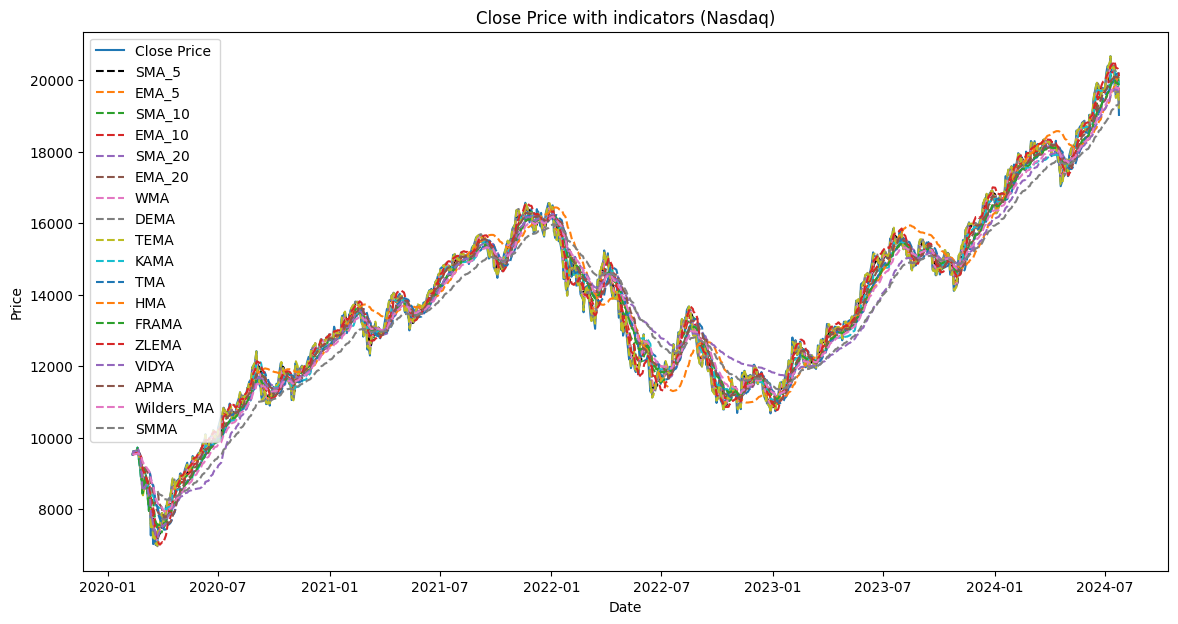

In [52]:


plt.figure(figsize=(14, 7))
plt.plot(dataset['Date'], dataset['Close'], label='Close Price')
plt.plot(dataset['Date'], dataset['SMA_5'],
         label='SMA_5', linestyle='--', color='black')
plt.plot(dataset['Date'], dataset['EMA_5'], label='EMA_5', linestyle='--')
plt.plot(dataset['Date'], dataset['SMA_10'], label='SMA_10', linestyle='--')
plt.plot(dataset['Date'], dataset['EMA_10'], label='EMA_10', linestyle='--')
plt.plot(dataset['Date'], dataset['SMA_20'], label='SMA_20', linestyle='--')
plt.plot(dataset['Date'], dataset['EMA_20'], label='EMA_20', linestyle='--')
plt.plot(dataset['Date'], dataset['WMA'], label='WMA', linestyle='--')
plt.plot(dataset['Date'], dataset['DEMA'], label='DEMA', linestyle='--')
plt.plot(dataset['Date'], dataset['TEMA'], label='TEMA', linestyle='--')
plt.plot(dataset['Date'], dataset['KAMA'], label='KAMA', linestyle='--')
plt.plot(dataset['Date'], dataset['TMA'], label='TMA', linestyle='--')
plt.plot(dataset['Date'], dataset['HMA'], label='HMA', linestyle='--')
plt.plot(dataset['Date'], dataset['FRAMA'], label='FRAMA', linestyle='--')
plt.plot(dataset['Date'], dataset['ZLEMA'], label='ZLEMA', linestyle='--')
plt.plot(dataset['Date'], dataset['VIDYA'], label='VIDYA', linestyle='--')
plt.plot(dataset['Date'], dataset['APMA'], label='APMA', linestyle='--')
plt.plot(dataset['Date'], dataset['Wilders_MA'],
         label='Wilders_MA', linestyle='--')
plt.plot(dataset['Date'], dataset['SMMA'], label='SMMA', linestyle='--')
plt.title('Close Price with indicators (Nasdaq)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [6]:
print(dataset['Close'])

0        9517.860352
1        9613.200195
2        9595.700195
3        9623.580078
4        9629.799805
            ...     
1063    19799.140625
1064    19705.089844
1065    19522.619141
1066    19822.869141
1067    19754.339844
Name: Close, Length: 1068, dtype: float64


In [10]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt


# Calculate Root Mean Squared Error
# rmse_sma = sqrt(mean_squared_error(
#     dataset['Close'][-20:], dataset['SMA'][-20:]))
# rmse_ema = sqrt(mean_squared_error(dataset['Close'], dataset['EMA']))
# rmse_wma = sqrt(mean_squared_error(
#     dataset['Close'][-20:], dataset['WMA'][-20:]))
# rmse_dema = sqrt(mean_squared_error(dataset['Close'], dataset['DEMA']))
# rmse_tema = sqrt(mean_squared_error(dataset['Close'], dataset['TEMA']))


n = 0
# remove VAMA
list_type = ['SMA_5', 'EMA_5', 'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'WMA', 'DEMA', 'TEMA', 'KAMA',
             'TMA', 'HMA', 'FRAMA', 'ZLEMA', 'VIDYA', 'APMA', 'Wilders_MA', 'SMMA']
rmse_values = []

while (n <= len(list_type)-1):
    rmse = sqrt(mean_squared_error(
        dataset['Close'][-20:], dataset[list_type[n]][-20:]))

    print(n+1, ". RMSE ", list_type[n], " =", rmse)
    rmse_values.append((list_type[n], rmse))
    n += 1

rmse_values.sort(key=lambda x: x[1])
print("****************************************")
print("top 10 RMSE values:")
for item in rmse_values[:10]:
    print(f"RMSE {item[0]} = {item[1]}")
print("****************************************")
n = 0
mae_values = []
while (n <= len(list_type)-1):
    mae = mean_absolute_error(
        dataset['Close'][-20:], dataset[list_type[n]][-20:])

    print(n+1, ". MAE ", list_type[n], " =", mae)
    mae_values.append((list_type[n], mae))
    n += 1

mae_values.sort(key=lambda x: x[1])
print("****************************************")
print("top 10 MAE values:")
for item in mae_values[:10]:
    print(f"MAE {item[0]} = {item[1]}")

print("****************************************")
print("Comparison between RMSE and MAE:")
for i in range(10):
    rmse_item = rmse_values[i]
    mae_item = mae_values[i]
    print(f"{i+1}. {rmse_item[0]
                    } -> RMSE = {rmse_item[1]}, MAE = {mae_item[1]}")

1 . RMSE  SMA_5  = 246.24147693744152
2 . RMSE  EMA_5  = 198.29754623783197
3 . RMSE  SMA_10  = 366.6859159755454
4 . RMSE  EMA_10  = 298.04705486039444
5 . RMSE  SMA_20  = 496.2245959378205
6 . RMSE  EMA_20  = 477.71378169922565
7 . RMSE  WMA  = 183.3821133648512
8 . RMSE  DEMA  = 120.10658871719878
9 . RMSE  TEMA  = 82.77002287109559
10 . RMSE  KAMA  = 357.8631043084738
11 . RMSE  TMA  = 493.4514368015611
12 . RMSE  HMA  = 702.0167421599203
13 . RMSE  FRAMA  = 458.67966943536396
14 . RMSE  ZLEMA  = 373.8959288987939
15 . RMSE  VIDYA  = 680.9630238631942
16 . RMSE  APMA  = 375.6810213221416
17 . RMSE  Wilders_MA  = 611.5129369174792
18 . RMSE  SMMA  = 1069.0324872571491
****************************************
top 10 RMSE values:
RMSE TEMA = 82.77002287109559
RMSE DEMA = 120.10658871719878
RMSE WMA = 183.3821133648512
RMSE EMA_5 = 198.29754623783197
RMSE SMA_5 = 246.24147693744152
RMSE EMA_10 = 298.04705486039444
RMSE KAMA = 357.8631043084738
RMSE SMA_10 = 366.6859159755454
RMSE ZLEMA

In [9]:
# clear data
# rmse_values.clear()
# mae_values.clear()

SegRNN Model 

In [10]:
# import torch
# import torch.nn as nn
# import math


# class Model(nn.Module):
#     def __init__(self, configs):
#         super(Model, self).__init__()

#         # remove this, the performance will be bad
#         self.lucky = nn.Embedding(configs.enc_in, configs.d_model // 2)

#         self.seq_len = configs.seq_len
#         self.pred_len = configs.pred_len
#         self.enc_in = configs.enc_in
#         self.patch_len = configs.patch_len
#         self.d_model = configs.d_model

#         self.linear_patch = nn.Linear(self.patch_len, self.d_model)
#         self.relu = nn.ReLU()

#         self.gru = nn.GRU(
#             input_size=self.d_model,
#             hidden_size=self.d_model,
#             num_layers=1,
#             bias=True,
#             batch_first=True,
#         )

#         self.pos_emb = nn.Parameter(torch.randn(
#             self.pred_len // self.patch_len, self.d_model // 2))
#         self.channel_emb = nn.Parameter(
#             torch.randn(self.enc_in, self.d_model // 2))

#         self.dropout = nn.Dropout(configs.dropout)
#         self.linear_patch_re = nn.Linear(self.d_model, self.patch_len)

#     def forward(self, x, x_mark, y_true, y_mark):
#         seq_last = x[:, -1:, :].detach()
#         x = x - seq_last

#         B, L, C = x.shape
#         N = self.seq_len // self.patch_len
#         M = self.pred_len // self.patch_len
#         W = self.patch_len
#         d = self.d_model

#         # B, L, C -> B, C, L -> B * C, N, W
#         xw = x.permute(0, 2, 1).reshape(B * C, N, -1)
#         xd = self.linear_patch(xw)  # B * C, N, W -> B * C, N, d
#         enc_in = self.relu(xd)

#         # 1, B * C, d -> 1, B * C, M * d -> 1, B * C * M, d
#         enc_out = self.gru(enc_in)[1].repeat(1, 1, M).view(1, -1, self.d_model)

#         dec_in = torch.cat([
#             # M, d//2 -> 1, M, d//2 -> B * C, M, d//2
#             self.pos_emb.unsqueeze(0).repeat(B*C, 1, 1),
#             # C, d//2 -> C, 1, d//2 -> B * C, M, d//2
#             self.channel_emb.unsqueeze(1).repeat(B, M, 1)
#             # B * C, M, d -> B * C * M, d -> B * C * M, 1, d
#         ], dim=-1).flatten(0, 1).unsqueeze(1)

#         dec_out = self.gru(dec_in, enc_out)[0]  # B * C * M, 1, d

#         yd = self.dropout(dec_out)
#         yw = self.linear_patch_re(yd)  # B * C * M, 1, d -> B * C * M, 1, W
#         y = yw.reshape(B, C, -1).permute(0, 2, 1)  # B, C, H

#         y = y + seq_last

#         return y

Main Transformers model

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import yfinance as yf
from keras import layers
from sklearn.metrics import mean_absolute_percentage_error, root_mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import MinMaxScaler
import time
import timeit
from datetime import datetime
from math import sqrt

In [2]:
class ETL:
    """
    ticker: str
    period: string
    test_size: float betwee 0 and 1
    n_input: int
    timestep: int
    Extracts data for stock with ticker `ticker` from yf api,
    splits the data into train and test sets by date,
    reshapes the data into np.array of shape [#weeks, 5, 1],
    converts our problem into supervised learning problem.
    """

    def __init__(self, datainput, test_size=0.2, n_input=5, timestep=5, normalize_bool=False, scaler=None) -> None:
        self.datainput = datainput
        self.test_size = test_size
        self.n_input = n_input
        self.timestep = timestep
        self.normalize_bool = normalize_bool
        self.scaler = scaler
        self.df = self.extract_historic_data()
        self.train, self.test = self.etl()
        self.X_train, self.y_train = self.to_supervised(self.train)
        self.X_test, self.y_test = self.to_supervised(self.test)

        if self.normalize_bool:
            print('normalized', normalize_bool)
            self.scaler = scaler
        else:
            print('not normalized', normalize_bool)
            self.scaler = None

    def extract_historic_data(self) -> pd.Series:
        """
        Extracts historic data and optionally normalizes it.
        """
        # data = self.datainput
        if self.normalize_bool:
            data = self.scaler.fit_transform(
                self.datainput.values.reshape(-1, 1))
            return data
        else:
            data = self.datainput
            return data

    def split_data(self) -> tuple:
        """
        Splits our pd.Series into train and test series with
        test series representing test_size * 100 % of data.
        """
        # data = self.extract_historic_data()
        data = self.df
        if len(data) != 0:
            train_idx = round(len(data) * (1-self.test_size))
            train = data[:train_idx]
            test = data[train_idx:]
            train = np.array(train)
            test = np.array(test)
            return train[:, np.newaxis], test[:, np.newaxis]
        else:
            raise Exception('Data set is empty, cannot split.')

    def window_and_reshape(self, data) -> np.array:
        """
        Reformats data into shape our model needs,
        namely, [# samples, timestep, # feautures]
        samples
        """
        NUM_FEATURES = 1
        samples = int(data.shape[0] / self.timestep)
        result = np.array(np.array_split(data, samples))
        output = result.reshape((samples, self.timestep, NUM_FEATURES))
        print(output.shape)
        return output

    def transform(self, train, test) -> np.array:
        train_remainder = train.shape[0] % self.timestep
        test_remainder = test.shape[0] % self.timestep
        if train_remainder != 0 and test_remainder != 0:
            train = train[train_remainder:]
            test = test[test_remainder:]
        elif train_remainder != 0:
            train = train[train_remainder:]
        elif test_remainder != 0:
            test = test[test_remainder:]
        # print("train:", train, "test:", test)
        return self.window_and_reshape(train), self.window_and_reshape(test)

    def etl(self) -> tuple[np.array, np.array]:
        """
        Runs complete ETL
        """
        train, test = self.split_data()
        return self.transform(train, test)

    def to_supervised(self, train, n_out=5) -> tuple:
        """
        Converts our time series prediction problem to a
        supervised learning problem.
        """
        # flatted the data
        data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
        X, y = [], []
        in_start = 0
        # step over the entire history one time step at a time
        for _ in range(len(data)):
            # define the end of the input sequence
            in_end = in_start + self.n_input
            out_end = in_end + n_out
            # ensure we have enough data for this instance
            if out_end <= len(data):
                x_input = data[in_start:in_end, 0]
                x_input = x_input.reshape((len(x_input), 1))
                X.append(x_input)
                y.append(data[in_end:out_end, 0])
                # move along one time step
                in_start += 1
        print(np.array(X), np.array(y))
        return np.array(X), np.array(y)

# *******************************
# Implementing a Transformer


def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0.2, epsilon=1e-6, attention_axes=None, kernel_size=1):
    """
    Creates a single transformer block.
    """
    x = layers.LayerNormalization(epsilon=epsilon)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout,
        attention_axes=attention_axes
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=epsilon)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=kernel_size,
                      activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=kernel_size)(x)
    return x + res


def build_transfromer(head_size, num_heads, ff_dim, num_trans_blocks, mlp_units, dropout=0.2, mlp_dropout=0.2, attention_axes=None, epsilon=1e-6, kernel_size=1):
    """
    Creates final model by building many transformer blocks.
    """
    n_timesteps, n_features, n_outputs = 5, 1, 5
    inputs = tf.keras.Input(shape=(n_timesteps, n_features))
    x = inputs
    for _ in range(num_trans_blocks):
        x = transformer_encoder(x, head_size=head_size, num_heads=num_heads, ff_dim=ff_dim,
                                dropout=dropout, attention_axes=attention_axes, kernel_size=kernel_size, epsilon=epsilon)

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)
    for dim in mlp_units:
        x = layers.Dense(dim, activation="relu")(x)
        x = layers.Dropout(mlp_dropout)(x)

    outputs = layers.Dense(n_outputs)(x)
    return tf.keras.Model(inputs, outputs)


def fit_transformer(transformer: tf.keras.Model, x_train, y_train, X_val, y_val, display_loss=False):
    """
    Compiles and fits our transformer.
    """
    transformer.compile(
        loss="mse",
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        metrics=["mae", 'mape'])

    callbacks = [tf.keras.callbacks.EarlyStopping(
        monitor='loss', patience=10, restore_best_weights=True)]
    start = time.time()
    # hist = transformer.fit(data.X_train, data.y_train, batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
    hist = transformer.fit(x_train, y_train, validation_data=(X_val, y_val),
                           batch_size=32, epochs=25, verbose=1, callbacks=callbacks)
    print("time used", time.time() - start)
    history_df = pd.DataFrame(hist.history)

    if display_loss:
        history_df['val_loss'].plot()
        plt.title('Validation Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Validation'], loc='upper right')
        plt.show()
        history_df['loss'].plot()
        plt.title('Training Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train'], loc='upper right')
        plt.show()

        # Display minimum validation loss
        min_val_loss = history_df['val_loss'].min()
        print("Minimum validation loss: {:.4f}".format(min_val_loss))
        # Plot mae
        history_df.loc[:, ['mae', 'val_mae']].plot()
        plt.title('Model MAE')
        plt.ylabel('MAE')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.show()
        # Display minimum validation mae and mape
        min_val_mae = history_df['val_mae'].min()
        min_val_mape = history_df['val_mape'].min()
        print("Minimum validation MAE: {:.4f}".format(min_val_mae))
        print("Minimum validation MAPE: {:.4f}".format(min_val_mape))

    return hist

# **********************


class PredictAndForecast:
    """
    model: tf.keras.Model
    train: np.array
    test: np.array
    Takes a trained model, train, and test datasets and returns predictions
    of len(test) with same shape.
    """

    def __init__(self, model, train, test, n_input=5, scaler=None, normalize_bool=False) -> None:
        self.model = model
        self.train = train
        self.test = test
        self.n_input = n_input
        self.scaler = scaler
        self.normalize_bool = normalize_bool
        self.predictions = self.get_predictions()

    def forecast(self, history) -> np.array:
        """
        Given last weeks actual data, forecasts next weeks prices.
        """
        # flatten data
        data = np.array(history)
        data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
        # retrieve last observations for input data
        input_x = data[-self.n_input:, :]
        # reshape into [1, n_input, 1]
        input_x = input_x.reshape((1, len(input_x), input_x.shape[1]))
        # forecast the next week
        yhat = self.model.predict(input_x, verbose=0)
        # we only want the vector forecast
        yhat = yhat[0]
        return yhat

    def get_predictions(self) -> np.array:
        """
        compiles models predictions week by week over entire
        test set.
        """
        # history is a list of weekly data
        history = [x for x in self.train]
        # walk-forward validation over each week
        predictions = []
        for i in range(len(self.test)):
            yhat_sequence = self.forecast(history)
            # store the predictions
            predictions.append(yhat_sequence)
            # get real observation and add to history for predicting the next week
            history.append(self.test[i, :])
        predictions = np.array(predictions)
        # if self.normalize_bool:
        # Inverse transform to get back to original scale
        #    predictions = self.scaler.inverse_transform(
        #        predictions.reshape(-1, 1)).reshape(predictions.shape)
        return predictions


class Evaluate:

    def __init__(self, actual, predictions, normalize_bool, scaler) -> None:
        if normalize_bool == True:
            actual = scaler.inverse_transform(
                actual.reshape(-1, 1)).reshape(actual.shape)
            predictions = scaler.inverse_transform(
                predictions.reshape(-1, 1)).reshape(predictions.shape)
        self.actual = actual
        self.predictions = predictions
        self.var_ratio = self.compare_var()
        self.mape = self.evaluate_model_with_mape()
        self.rmse = self.evaluate_model_with_rmse()
        self.mae = self.evaluate_model_with_mae()
        self.r2 = self.evaluate_model_with_r2()

    def compare_var(self):
        return abs(1 - (np.var(self.predictions) / np.var(self.actual)))

    def evaluate_model_with_mape(self):
        return mean_absolute_percentage_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_rmse(self):
        return root_mean_squared_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_mae(self):
        return mean_absolute_error(self.actual.flatten(), self.predictions.flatten())

    def evaluate_model_with_r2(self):
        return r2_score(self.actual.flatten(), self.predictions.flatten())


def plot_results(train, test, preds, df, normalize_bool, scaler, title_suffix=None, xlabel='AAPL stock Price'):
    """
    Plots training data in blue, actual values in red, and predictions in green,
    over time.
    """

    fig, ax = plt.subplots(figsize=(20, 6))
    if not isinstance(df, pd.DataFrame):
        df = pd.DataFrame(df)
    # x = df.Close[-498:].index
    plot_test = test[1:]
    plot_preds = preds[1:]
    if normalize_bool == True:
        # Inverse transform to get back to original scale
        plot_test = scaler.inverse_transform(
            plot_test.reshape(-1, 1)).reshape(plot_test.shape)
        train = scaler.inverse_transform(
            train.reshape(-1, 1)).reshape(train.shape)
        plot_preds = scaler.inverse_transform(
            plot_preds.reshape(-1, 1)).reshape(plot_preds.shape)
        print("normalization convert active")

    # x = df[-(plot_test.shape[0]*plot_test.shape[1]):].index
    plot_test = plot_test.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_preds = plot_preds.reshape((plot_test.shape[0]*plot_test.shape[1], 1))
    plot_train = train.reshape((train.shape[0]*train.shape[1], 1))
    print(f'plot_train shape: {plot_train.shape}')
    print(f'plot_test shape: {plot_test.shape}')
    print(f'plot_preds shape: {plot_preds.shape}')

    x_train = df[:len(plot_train)].index
    x_test = df[len(plot_train):len(plot_train) + len(plot_test)].index

    ax.plot(x_train, plot_train, label='Train', color='blue')
    ax.plot(x_test, plot_test, label='actual', color='red')
    ax.plot(x_test, plot_preds, label='preds', color='green')
    if title_suffix == None:
        ax.set_title('Predictions vs. Actual')
    else:
        ax.set_title(f'Predictions vs. Actual, {title_suffix}')
    ax.set_xlabel('Date')
    ax.set_ylabel(xlabel)
    ax.legend()
    plt.show()

Comparison between RMSE and MAE:
1. TEMA -> RMSE = 82.77002287109559, MAE = 62.72709258243849
2. DEMA -> RMSE = 120.10658871719878, MAE = 91.31564249421808
3. WMA -> RMSE = 183.3821133648512, MAE = 144.49500651041672
4. EMA_5 -> RMSE = 198.29754623783197, MAE = 153.5413996948202
5. SMA_5 -> RMSE = 246.24147693744152, MAE = 187.78255859375003
6. EMA_10 -> RMSE = 298.04705486039444, MAE = 248.38187324143365
7. KAMA -> RMSE = 357.8631043084738, MAE = 288.8012514772814
8. SMA_10 -> RMSE = 366.6859159755454, MAE = 289.8100097656252
9. ZLEMA -> RMSE = 373.8959288987939, MAE = 298.667564304378
10. APMA -> RMSE = 375.6810213221416, MAE = 326.82132329058385

In [3]:
ticker = 'NDX'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset['Close'] = dataset['Close']


def kama_indicator(price, period=10, period_fast=2, period_slow=30):
    price = pd.Series(price)
    # Efficiency Ratio
    change = abs(price-price.shift(period))
    volatility = (abs(price-price.shift())).rolling(period).sum()
    er = change/volatility

    # Smoothing Constant
    sc_fatest = 2/(period_fast + 1)
    sc_slowest = 2/(period_slow + 1)
    sc = (er * (sc_fatest - sc_slowest) + sc_slowest)**2

    # KAMA
    kama = np.zeros_like(price)
    kama[period-1] = price[period-1]

    for i in range(period, len(price)):
        kama[i] = kama[i-1] + sc[i] * (price[i] - kama[i-1])

    kama[kama == 0] = np.nan

    return pd.Series(kama)


def calculate_TEMA(data, period):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    ema3 = ema2.ewm(span=period, adjust=False).mean()
    tema = 3 * ema1 - 3 * ema2 + ema3
    return tema


def calculate_DEMA(data, period):
    ema1 = data.ewm(span=period, adjust=False).mean()
    ema2 = ema1.ewm(span=period, adjust=False).mean()
    dema = 2 * ema1 - ema2
    return dema


def calculate_ZLEMA(prices, period):
    prices = pd.Series(prices)  # Ensure prices is a pandas Series
    lag = period // 2
    adjusted_prices = [
        2 * prices[i] - (prices[i - lag] if i >= lag else prices[0]) for i in range(len(prices))
    ]
    adjusted_prices = pd.Series(adjusted_prices)
    zlema = adjusted_prices.ewm(span=period, adjust=False).mean()
    return pd.Series(zlema)


def adaptive_period_moving_average(prices, min_period=5, max_period=30):
    atr = np.zeros_like(prices)
    adjusted_periods = np.zeros_like(prices)
    moving_averages = np.full_like(prices, np.nan)

    for i in range(1, len(prices)):
        atr[i] = atr[i-1] + (abs(prices[i] - prices[i-1]) - atr[i-1]) / 14

        min_volatility = atr[1:i+1].min()
        max_volatility = atr[1:i+1].max()

        if max_volatility == min_volatility:
            adjusted_period = min_period
        else:
            adjusted_period = int(((max_period - min_period) / (
                max_volatility - min_volatility)) * (atr[i] - min_volatility) + min_period)

        adjusted_periods[i] = adjusted_period

        if i >= adjusted_period:
            moving_averages[i] = np.mean(prices[i-adjusted_period+1:i+1])

    return pd.Series(moving_averages)


def weighted_moving_average(data, periods):
    weights = np.arange(1, periods + 1)
    wma = data.rolling(periods).apply(
        lambda x: np.dot(x, weights) / weights.sum(), raw=True)
    return wma

[*********************100%%**********************]  1 of 1 completed


In [4]:
list_type_used = ['TEMA', 'DEMA', 'WMA', 'EMA_5',
                  'SMA_5', 'EMA_10', 'KAMA', 'SMA_10', 'ZLEMA', 'APMA']
# ticker = 'NDX'
ticker = 'NDX'
# # timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]


def apply_moving_average(dataset, ma_type):
    ma_functions = {
        0: lambda x: calculate_TEMA(x['Close'], 5),  # TEMA
        1: lambda x: calculate_DEMA(x['Close'], 5),  # DEMA
        2: lambda x: weighted_moving_average(x['Close'], 5),  # WMA
        3: lambda x: x['Close'].ewm(span=5, adjust=False).mean(),  # EMA_5
        4: lambda x: x['Close'].rolling(window=5).mean(),  # SMA_5
        5: lambda x: x['Close'].ewm(span=10, adjust=False).mean(),  # EMA_10
        6: lambda x: kama_indicator(x['Close']),  # KAMA
        7: lambda x: x['Close'].rolling(window=10).mean(),  # SMA_10
        8: lambda x: calculate_ZLEMA(x['Close'].tolist(), 28),  # ZLEMA
        9: lambda x: adaptive_period_moving_average(x['Close'].values)  # APMA
    }
    if ma_type not in ma_functions:
        raise ValueError(f"Invalid ma_type: {
                         ma_type}. Must be between 0 and 9.")
    return ma_functions[ma_type](dataset)


for j in range(len(list_type_used)):
    dataset = yf.download(ticker, start='1990-01-01',
                          end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
    dataset = dataset[['Close']]
    dataset_ma = apply_moving_average(dataset, j)
    dataset_ma.dropna(inplace=True)
    print(f"MA type: {list_type_used[j]}")
    print(dataset_ma)
    print("******************")
    if j >= 9:
        print("*Done*")

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_7721/2130994814.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[period-1] = price[period-1]
/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_7721/2130994814.py:25: FutureWarning: Se

MA type: TEMA
Date
2020-02-11     9517.860352
2020-02-12     9584.951353
2020-02-13     9600.885380
2020-02-14     9624.735653
2020-02-18     9636.691062
                  ...     
2024-07-18    19722.946772
2024-07-19    19509.033390
2024-07-22    19651.381285
2024-07-23    19687.065705
2024-07-24    19206.805377
Name: Close, Length: 1069, dtype: float64
******************
MA type: DEMA
Date
2020-02-11     9517.860352
2020-02-12     9570.826931
2020-02-13     9589.353552
2020-02-14     9613.781612
2020-02-18     9629.182649
                  ...     
2024-07-18    19852.314663
2024-07-19    19631.608406
2024-07-22    19688.212373
2024-07-23    19690.259723
2024-07-24    19297.206771
Name: Close, Length: 1069, dtype: float64
******************
MA type: WMA
Date
2020-02-18     9611.645378
2020-02-19     9652.546159
2020-02-20     9649.755469
2020-02-21     9585.609570
2020-02-24     9409.044141
                  ...     
2024-07-18    20001.541406
2024-07-19    19800.999740
2024-07-22  

[*********************100%%**********************]  1 of 1 completed


(171, 5, 1)
(42, 5, 1)
[[[ 9517.86035156]
  [ 9584.95135272]
  [ 9600.8853805 ]
  [ 9624.73565297]
  [ 9636.69106197]]

 [[ 9584.95135272]
  [ 9600.8853805 ]
  [ 9624.73565297]
  [ 9636.69106197]
  [ 9701.58379951]]

 [[ 9600.8853805 ]
  [ 9624.73565297]
  [ 9636.69106197]
  [ 9701.58379951]
  [ 9662.48100905]]

 ...

 [[14922.27177077]
  [14755.05387855]
  [14677.91449486]
  [14827.60203542]
  [14882.72680067]]

 [[14755.05387855]
  [14677.91449486]
  [14827.60203542]
  [14882.72680067]
  [15077.09289201]]

 [[14677.91449486]
  [14827.60203542]
  [14882.72680067]
  [15077.09289201]
  [14925.32474865]]] [[ 9701.58379951  9662.48100905  9514.35065361  9192.01871058
   8888.37614118]
 [ 9662.48100905  9514.35065361  9192.01871058  8888.37614118
   8803.16051471]
 [ 9514.35065361  9192.01871058  8888.37614118  8803.16051471
   8482.5056796 ]
 ...
 [15077.09289201 14925.32474865 14941.93630213 15026.24942853
  15288.62846856]
 [14925.32474865 14941.93630213 15026.24942853 15288.62846856
  

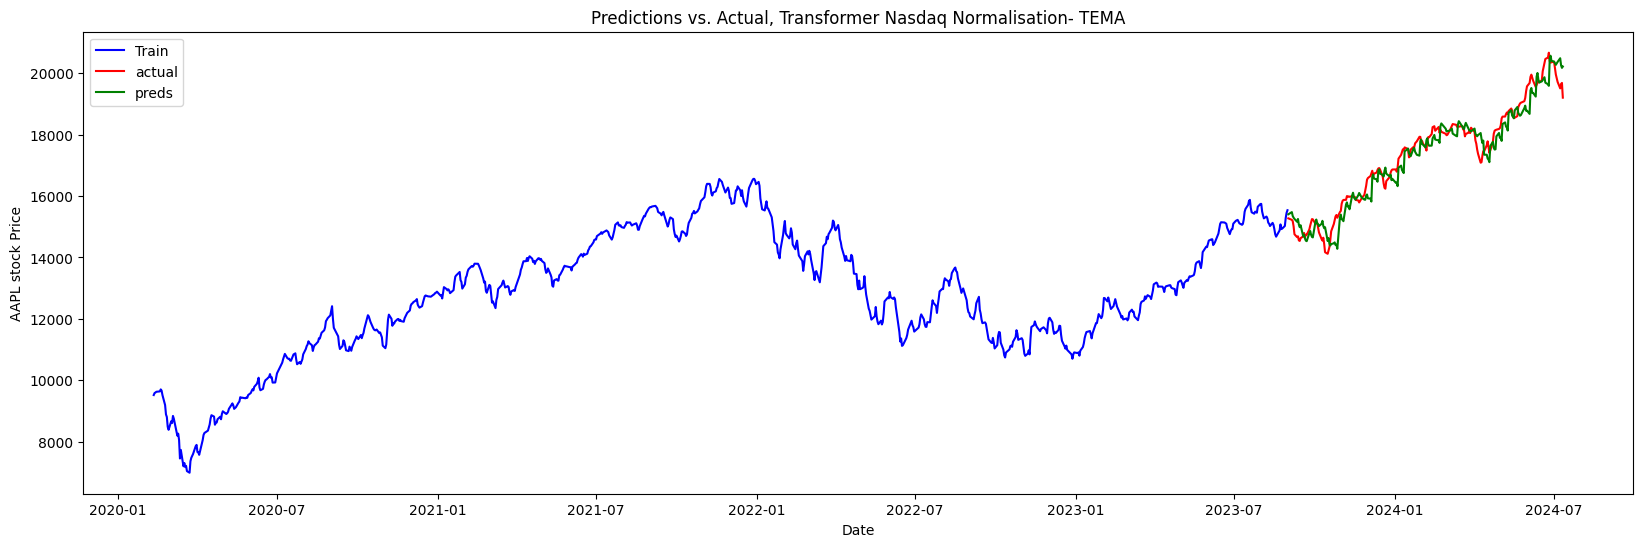

MAPE for TEMA: 0.01858794211225746
RMSE for TEMA: 406.4276776756685
MAE for TEMA: 318.10471287293586
R-squared for TEMA: 0.9401774697763863
(171, 5, 1)
(42, 5, 1)
[[[ 9517.86035156]
  [ 9570.82693142]
  [ 9589.35355179]
  [ 9613.78161169]
  [ 9629.18264934]]

 [[ 9570.82693142]
  [ 9589.35355179]
  [ 9613.78161169]
  [ 9629.18264934]
  [ 9685.50205225]]

 [[ 9589.35355179]
  [ 9613.78161169]
  [ 9629.18264934]
  [ 9685.50205225]
  [ 9663.72472726]]

 ...

 [[14938.59224635]
  [14790.99650824]
  [14705.39445012]
  [14800.53779354]
  [14842.54597866]]

 [[14790.99650824]
  [14705.39445012]
  [14800.53779354]
  [14842.54597866]
  [15001.42873084]]

 [[14705.39445012]
  [14800.53779354]
  [14842.54597866]
  [15001.42873084]
  [14904.10274696]]] [[ 9685.50205225  9663.72472726  9549.42448378  9283.28695463
   9006.39739723]
 [ 9663.72472726  9549.42448378  9283.28695463  9006.39739723
   8885.8821453 ]
 [ 9549.42448378  9283.28695463  9006.39739723  8885.8821453
   8588.14518905]
 ...
 [150

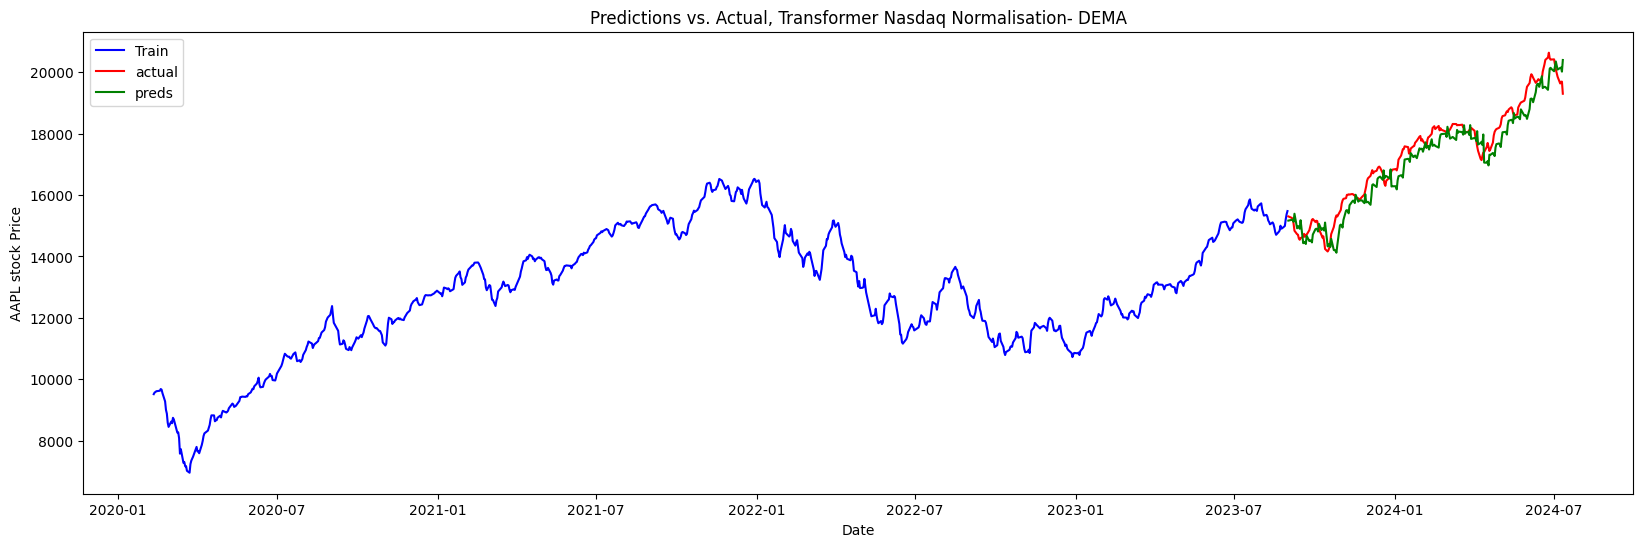

MAPE for DEMA: 0.023064520335931826
RMSE for DEMA: 470.2970152954239
MAE for DEMA: 397.37129261688983
R-squared for DEMA: 0.920191902677333
(170, 5, 1)
(42, 5, 1)
[[[ 9649.75546875]
  [ 9585.60957031]
  [ 9409.04414062]
  [ 9187.15546875]
  [ 9031.22532552]]

 [[ 9585.60957031]
  [ 9409.04414062]
  [ 9187.15546875]
  [ 9031.22532552]
  [ 8785.92994792]]

 [[ 9409.04414062]
  [ 9187.15546875]
  [ 9031.22532552]
  [ 8785.92994792]
  [ 8628.43196615]]

 ...

 [[14909.14186198]
  [14816.51582031]
  [14826.72200521]
  [14845.61132812]
  [14952.77988281]]

 [[14816.51582031]
  [14826.72200521]
  [14845.61132812]
  [14952.77988281]
  [14931.30273438]]

 [[14826.72200521]
  [14845.61132812]
  [14952.77988281]
  [14931.30273438]
  [14944.91341146]]] [[ 8785.92994792  8628.43196615  8675.30813802  8641.13085938
   8741.2422526 ]
 [ 8628.43196615  8675.30813802  8641.13085938  8741.2422526
   8743.77890625]
 [ 8675.30813802  8641.13085938  8741.2422526   8743.77890625
   8489.43942057]
 ...
 [149

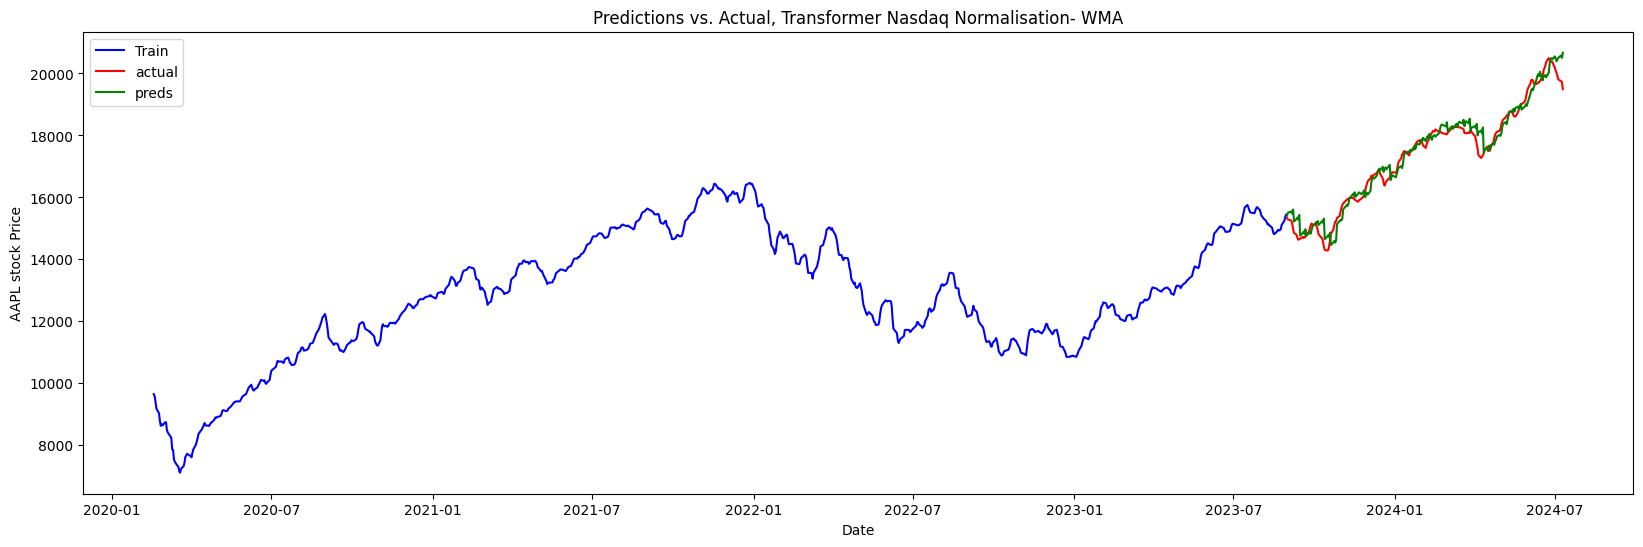

MAPE for WMA: 0.014418907317813506
RMSE for WMA: 318.84780652664904
MAE for WMA: 243.6982161458333
R-squared for WMA: 0.9626503695209988
(171, 5, 1)
(42, 5, 1)
[[[ 9517.86035156]
  [ 9549.64029948]
  [ 9564.99359809]
  [ 9584.52242477]
  [ 9599.61488474]]

 [[ 9549.64029948]
  [ 9564.99359809]
  [ 9584.52242477]
  [ 9599.61488474]
  [ 9639.32007941]]

 [[ 9564.99359809]
  [ 9584.52242477]
  [ 9599.61488474]
  [ 9639.32007941]
  [ 9635.49007898]]

 ...

 [[15045.81637772]
  [14935.81410858]
  [14855.48935364]
  [14882.55637899]
  [14891.35757297]]

 [[14935.81410858]
  [14855.48935364]
  [14882.55637899]
  [14891.35757297]
  [14976.92490542]]

 [[14855.48935364]
  [14882.55637899]
  [14891.35757297]
  [14976.92490542]
  [14923.43008017]]] [[ 9639.32007941  9635.49007898  9572.55686255  9408.2478693
   9217.12195193]
 [ 9635.49007898  9572.55686255  9408.2478693   9217.12195193
   9102.66788983]
 [ 9572.55686255  9408.2478693   9217.12195193  9102.66788983
   8880.66856718]
 ...
 [14976.

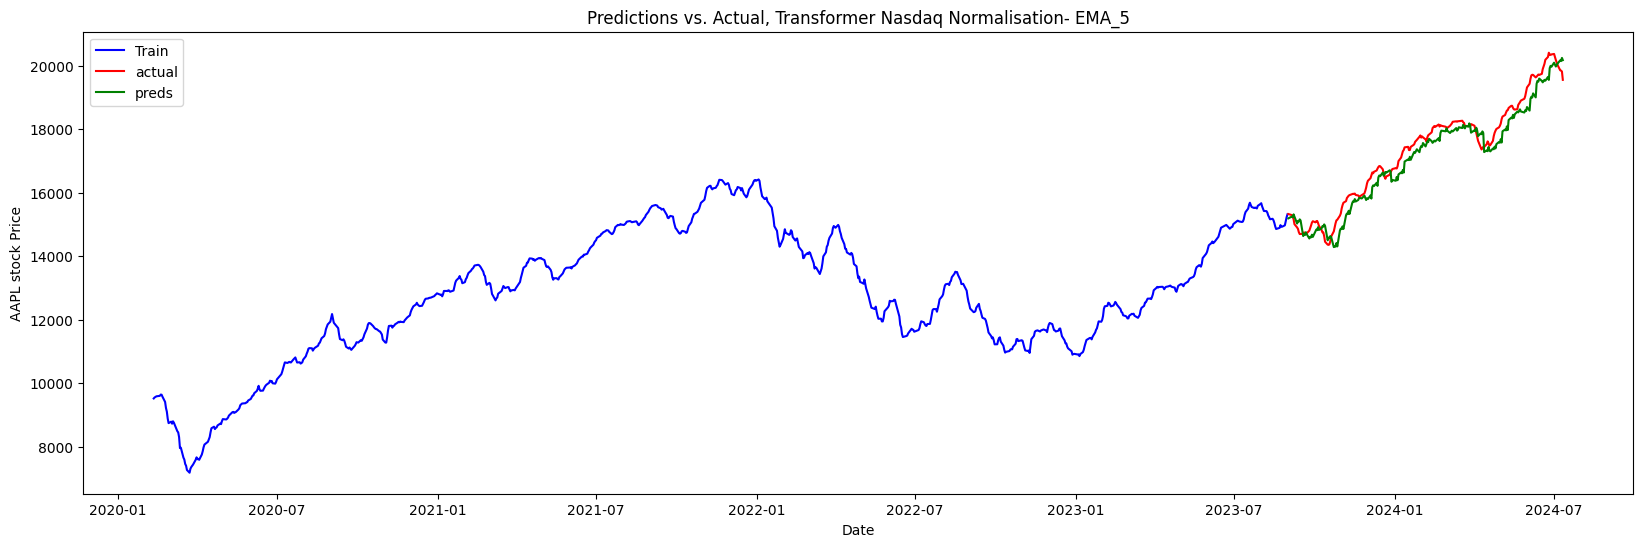

MAPE for EMA_5: 0.0191628849321658
RMSE for EMA_5: 383.5567672977531
MAE for EMA_5: 329.54234102859544
R-squared for EMA_5: 0.9453665527810879
(170, 5, 1)
(42, 5, 1)
[[[ 9639.128125  ]
  [ 9609.32617188]
  [ 9500.53613281]
  [ 9341.55019531]
  [ 9172.55605469]]

 [[ 9609.32617188]
  [ 9500.53613281]
  [ 9341.55019531]
  [ 9172.55605469]
  [ 8934.32402344]]

 [[ 9500.53613281]
  [ 9341.55019531]
  [ 9172.55605469]
  [ 8934.32402344]
  [ 8737.35195313]]

 ...

 [[14972.71796875]
  [14906.071875  ]
  [14852.29199219]
  [14826.55390625]
  [14880.871875  ]]

 [[14906.071875  ]
  [14852.29199219]
  [14826.55390625]
  [14880.871875  ]
  [14900.99804688]]

 [[14852.29199219]
  [14826.55390625]
  [14880.871875  ]
  [14900.99804688]
  [14950.39609375]]] [[ 8934.32402344  8737.35195313  8697.02207031  8648.94609375
   8664.05019531]
 [ 8737.35195313  8697.02207031  8648.94609375  8664.05019531
   8711.04824219]
 [ 8697.02207031  8648.94609375  8664.05019531  8711.04824219
   8608.28818359]
 ...
 

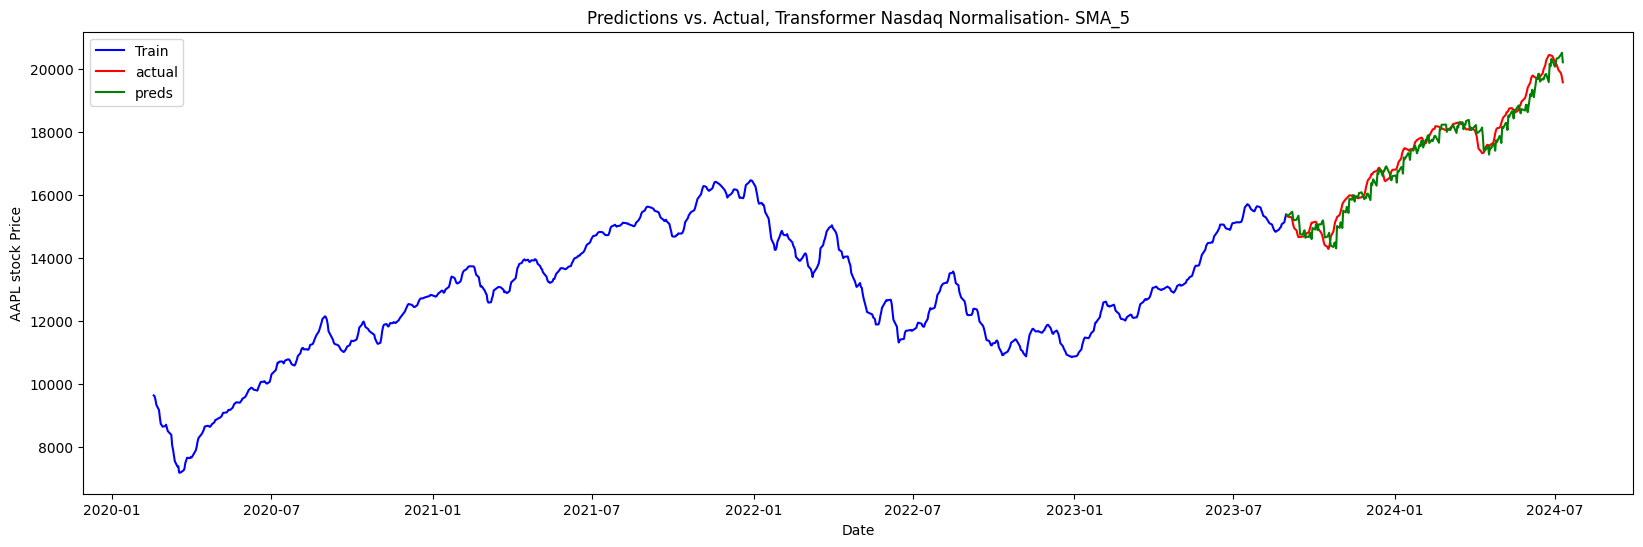

MAPE for SMA_5: 0.015152357001198775
RMSE for SMA_5: 324.06372346336053
MAE for SMA_5: 258.15147600446437
R-squared for SMA_5: 0.9612587069699238
(171, 5, 1)
(42, 5, 1)
[[[ 9517.86035156]
  [ 9535.19486861]
  [ 9546.1958371 ]
  [ 9560.2656991 ]
  [ 9572.90826376]]

 [[ 9535.19486861]
  [ 9546.1958371 ]
  [ 9560.2656991 ]
  [ 9572.90826376]
  [ 9599.42139194]]

 [[ 9546.1958371 ]
  [ 9560.2656991 ]
  [ 9572.90826376]
  [ 9599.42139194]
  [ 9604.58660761]]

 ...

 [[15157.12209153]
  [15076.88345131]
  [15007.42097721]
  [14994.56087766]
  [14978.99707462]]

 [[15076.88345131]
  [15007.42097721]
  [14994.56087766]
  [14978.99707462]
  [15009.7357102 ]]

 [[15007.42097721]
  [14994.56087766]
  [14978.99707462]
  [15009.7357102 ]
  [14974.59111374]]] [[ 9599.42139194  9604.58660761  9575.87821162  9485.65124275
   9367.32740174]
 [ 9604.58660761  9575.87821162  9485.65124275  9367.32740174
   9277.58783153]
 [ 9575.87821162  9485.65124275  9367.32740174  9277.58783153
   9124.69366614]
 ..

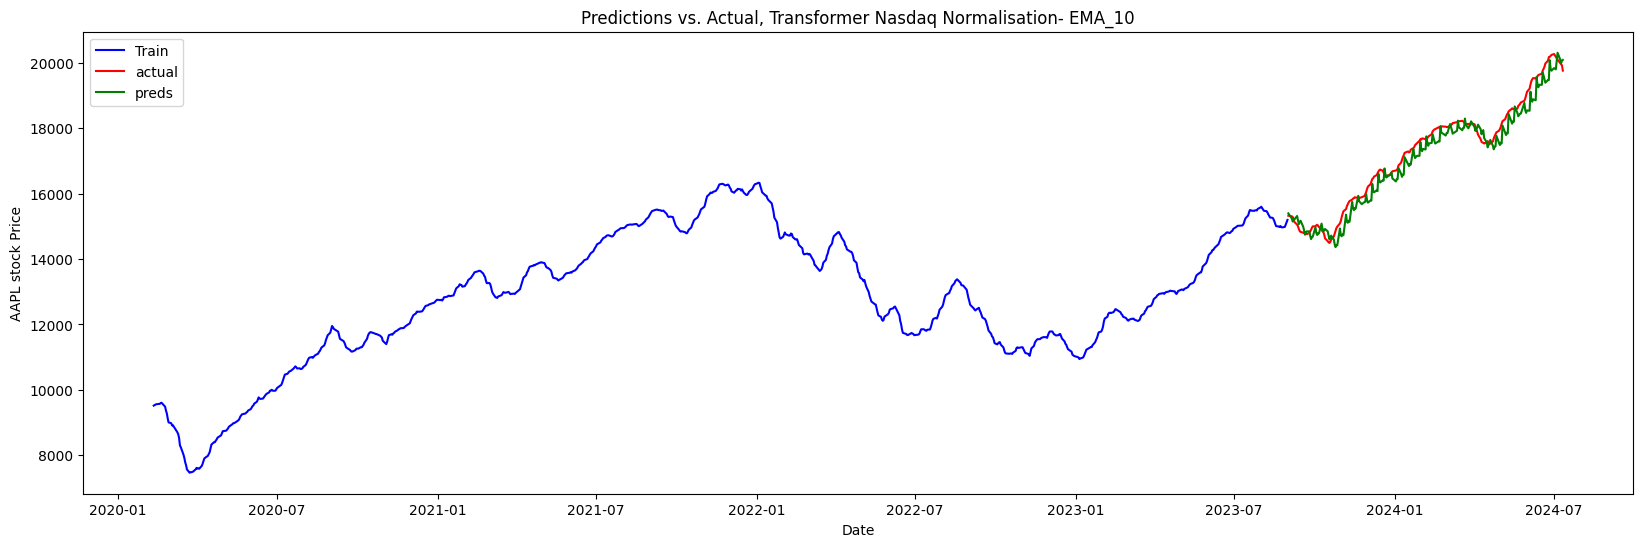

MAPE for EMA_10: 0.016083345595129268
RMSE for EMA_10: 330.22010843362455
MAE for EMA_10: 276.147435317751
R-squared for EMA_10: 0.9581127328114288
(169, 5, 1)
(42, 5, 1)
[[[ 8654.28060084]
  [ 8674.58488211]
  [ 8664.69853086]
  [ 8683.12338355]
  [ 8682.20039015]]

 [[ 8674.58488211]
  [ 8664.69853086]
  [ 8683.12338355]
  [ 8682.20039015]
  [ 8592.61716856]]

 [[ 8664.69853086]
  [ 8683.12338355]
  [ 8682.20039015]
  [ 8592.61716856]
  [ 8584.10418648]]

 ...

 [[15112.9760938 ]
  [15099.88679232]
  [15088.98848282]
  [15089.42113845]
  [15080.5796323 ]]

 [[15099.88679232]
  [15088.98848282]
  [15089.42113845]
  [15080.5796323 ]
  [15079.30322552]]

 [[15088.98848282]
  [15089.42113845]
  [15080.5796323 ]
  [15079.30322552]
  [15078.89965085]]] [[ 8592.61716856  8584.10418648  8557.73241467  8438.24926553
   8431.25154571]
 [ 8584.10418648  8557.73241467  8438.24926553  8431.25154571
   8357.62688522]
 [ 8557.73241467  8438.24926553  8431.25154571  8357.62688522
   8313.65811613]
 

/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_7436/2130994814.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[period-1] = price[period-1]
/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_7436/2130994814.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[i] = kama[i-1] + sc[i] * (price[i] - kama[i-1])


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - loss: 97308416.0000 - mae: 9163.2607 - mape: 71.4494 - val_loss: 1677330.1250 - val_mae: 961.3350 - val_mape: 5.5826
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2459495.7500 - mae: 1246.5420 - mape: 9.7207 - val_loss: 270239.5625 - val_mae: 439.0510 - val_mape: 2.5664
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1387538.7500 - mae: 920.1460 - mape: 7.1600 - val_loss: 91629.6953 - val_mae: 226.7920 - val_mape: 1.3217
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1320706.1250 - mae: 898.2126 - mape: 6.9836 - val_loss: 59725.6055 - val_mae: 177.2536 - val_mape: 1.0442
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1216100.0000 - mae: 861.3173 - mape: 6.6610 - val_loss: 67801.2578 - val_mae: 191.5244 - val_mape: 1.1258
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 1278833.2500 - mae: 892.1169 - mape: 6.9237 - val_loss: 114783.3594 - val_mae: 257.4240 - val_mape: 1.4901
Epoch 7/25
27/27

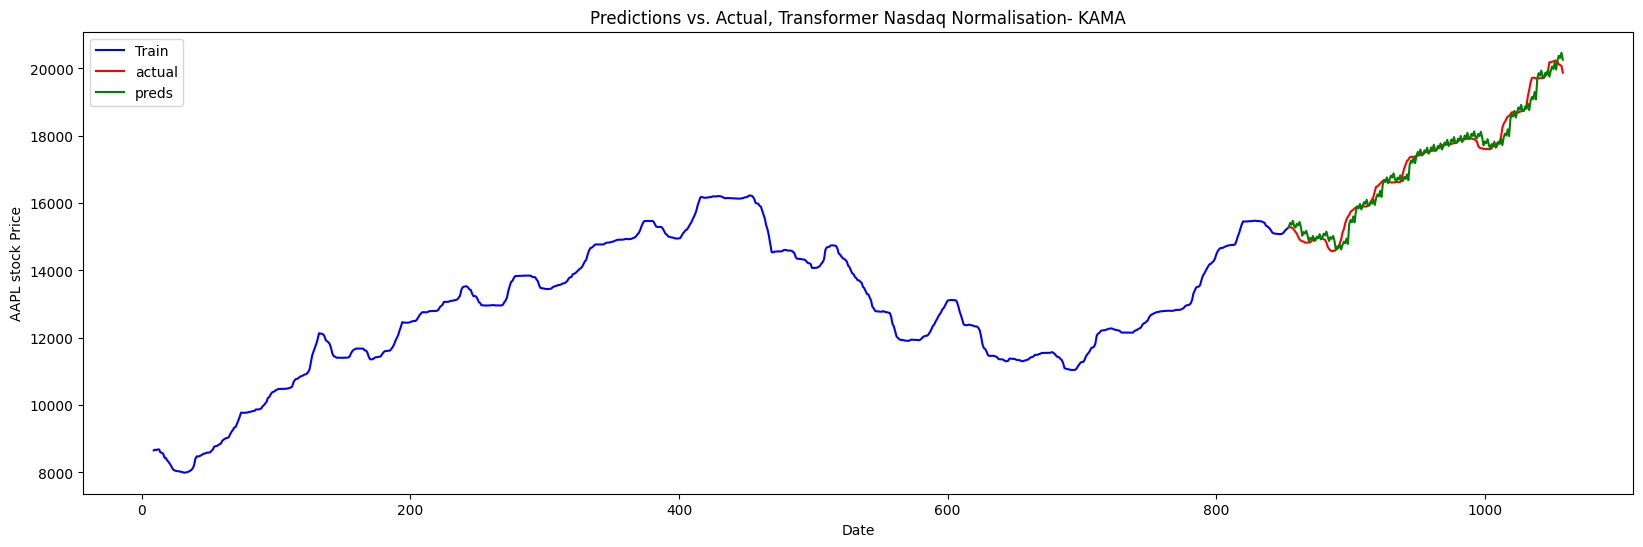

MAPE for KAMA: 0.010120684471379662
RMSE for KAMA: 236.83716470614795
MAE for KAMA: 171.78425329087537
R-squared for KAMA: 0.9781859633056562
(169, 5, 1)
(42, 5, 1)
[[[ 9173.3390625 ]
  [ 9098.77910156]
  [ 8995.24814453]
  [ 8918.303125  ]
  [ 8822.68613281]]

 [[ 9098.77910156]
  [ 8995.24814453]
  [ 8918.303125  ]
  [ 8822.68613281]
  [ 8672.82006836]]

 [[ 8995.24814453]
  [ 8918.303125  ]
  [ 8822.68613281]
  [ 8672.82006836]
  [ 8602.0840332 ]]

 ...

 [[15046.98789062]
  [14999.87197266]
  [14963.46298828]
  [14968.09794922]
  [14936.85800781]]

 [[14999.87197266]
  [14963.46298828]
  [14968.09794922]
  [14936.85800781]
  [14928.23398437]]

 [[14963.46298828]
  [14968.09794922]
  [14936.85800781]
  [14928.23398437]
  [14912.92099609]]] [[ 8672.82006836  8602.0840332   8519.2090332   8358.19804688
   8314.05703125]
 [ 8602.0840332   8519.2090332   8358.19804688  8314.05703125
   8169.91201172]
 [ 8519.2090332   8358.19804688  8314.05703125  8169.91201172
   8029.50898438]
 ...
 [

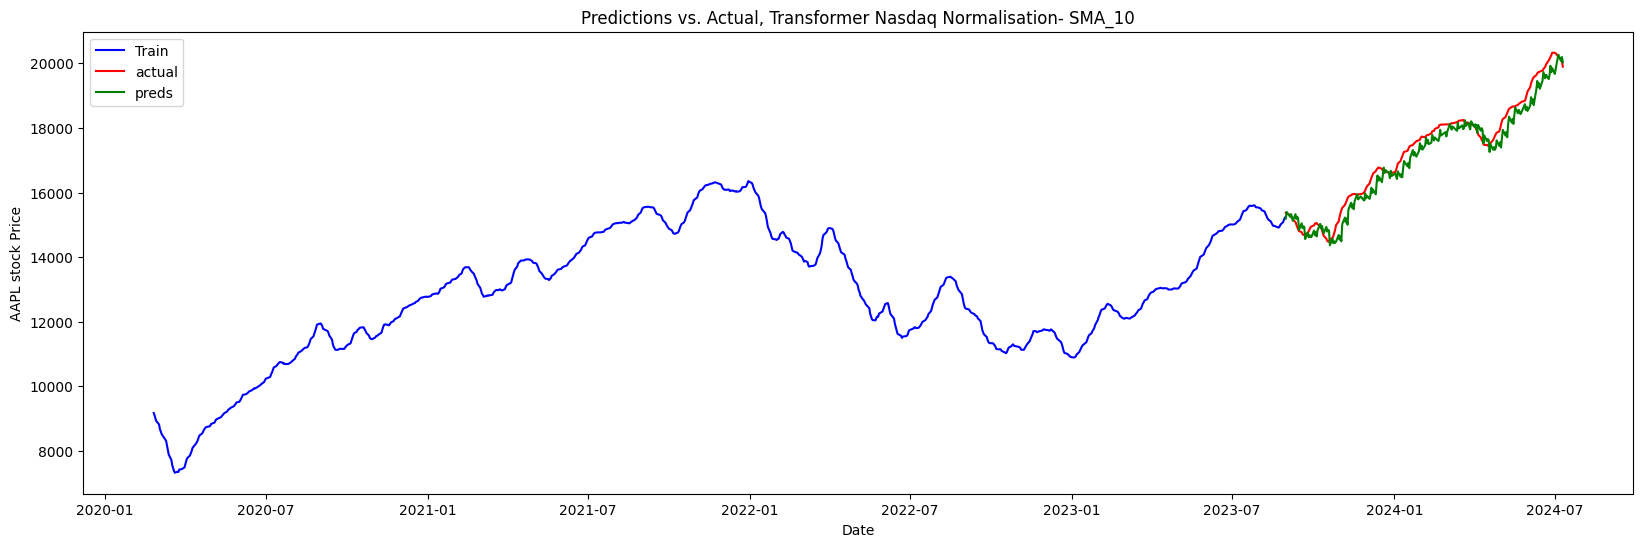

MAPE for SMA_10: 0.017433829038758467
RMSE for SMA_10: 352.8895510853876
MAE for SMA_10: 298.76539202008934
R-squared for SMA_10: 0.9527421400059349
(171, 5, 1)
(42, 5, 1)
[[[ 9517.86035156]
  [ 9531.01067484]
  [ 9540.84028616]
  [ 9553.83749434]
  [ 9566.79623665]]

 [[ 9531.01067484]
  [ 9540.84028616]
  [ 9553.83749434]
  [ 9566.79623665]
  [ 9591.12757108]]

 [[ 9540.84028616]
  [ 9553.83749434]
  [ 9566.79623665]
  [ 9591.12757108]
  [ 9601.24289754]]

 ...

 [[15251.16637634]
  [15142.85762302]
  [15038.70742057]
  [14977.78767389]
  [14941.19401966]]

 [[15142.85762302]
  [15038.70742057]
  [14977.78767389]
  [14941.19401966]
  [14941.28954255]]

 [[15038.70742057]
  [14977.78767389]
  [14941.19401966]
  [14941.28954255]
  [14901.05998358]]] [[ 9591.12757108  9601.24289754  9585.67583618  9520.55332431
   9426.16205248]
 [ 9601.24289754  9585.67583618  9520.55332431  9426.16205248
   9343.64461298]
 [ 9585.67583618  9520.55332431  9426.16205248  9343.64461298
   9206.52977706]


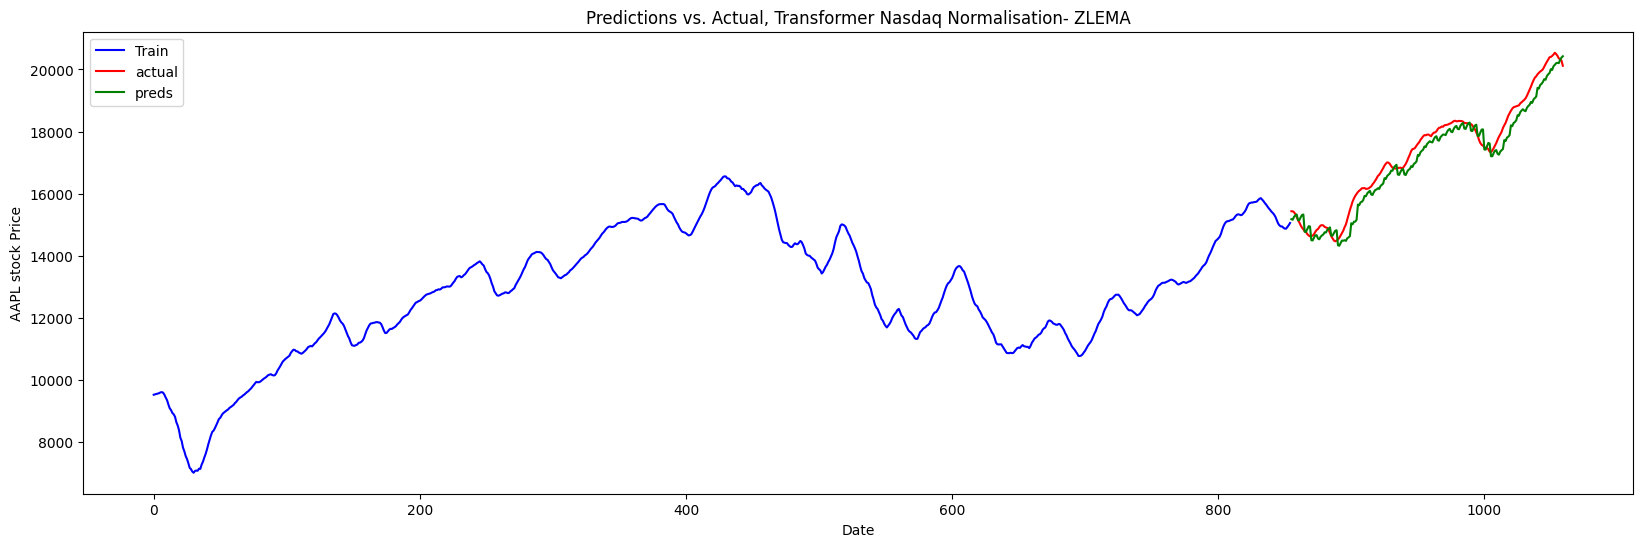

MAPE for ZLEMA: 0.01871518622324083
RMSE for ZLEMA: 372.00172126261725
MAE for ZLEMA: 322.6615389871319
R-squared for ZLEMA: 0.9516511444403692
(166, 5, 1)
(41, 5, 1)
[[[ 8050.89001953]
  [ 7939.97625732]
  [ 7883.78542074]
  [ 7832.19793701]
  [ 7765.32001529]]

 [[ 7939.97625732]
  [ 7883.78542074]
  [ 7832.19793701]
  [ 7765.32001529]
  [ 7805.83402344]]

 [[ 7883.78542074]
  [ 7832.19793701]
  [ 7765.32001529]
  [ 7805.83402344]
  [ 7706.9939071 ]]

 ...

 [[15036.99661458]
  [14986.71498326]
  [14970.95856585]
  [14997.99798177]
  [15022.04596354]]

 [[14986.71498326]
  [14970.95856585]
  [14997.99798177]
  [15022.04596354]
  [15048.20354353]]

 [[14970.95856585]
  [14997.99798177]
  [15022.04596354]
  [15048.20354353]
  [15068.58000837]]] [[ 7805.83402344  7706.9939071   7675.70085343  7608.93763951
   7624.49097842]
 [ 7706.9939071   7675.70085343  7608.93763951  7624.49097842
   7687.74383836]
 [ 7675.70085343  7608.93763951  7624.49097842  7687.74383836
   7724.05671038]
 ...


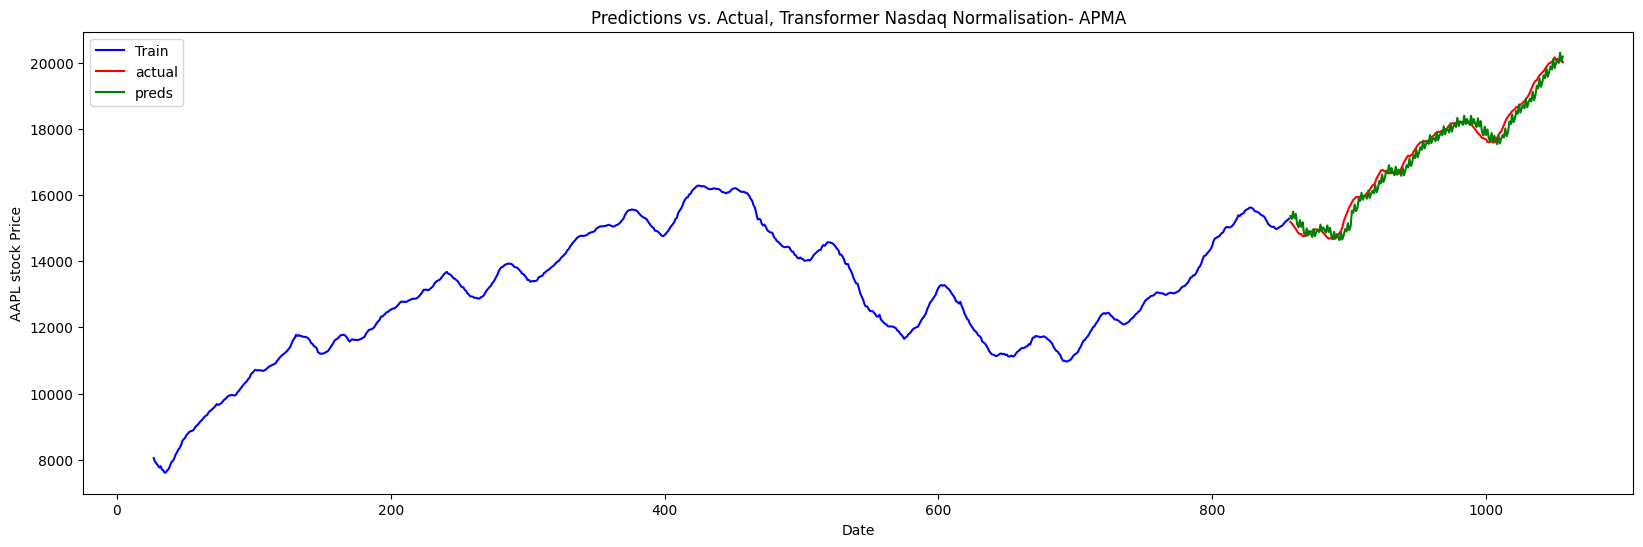

MAPE for APMA: 0.01093492204980877
RMSE for APMA: 232.36760294313848
MAE for APMA: 186.13429937152603
R-squared for APMA: 0.9787066623196489


In [6]:

list_type_used = ['TEMA', 'DEMA', 'WMA', 'EMA_5',
                  'SMA_5', 'EMA_10', 'KAMA', 'SMA_10', 'ZLEMA', 'APMA']
# ticker = 'NDX'
ticker = 'NDX'
# # timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset = dataset[['Close']]


def apply_moving_average(dataset, ma_type):
    ma_functions = {
        0: lambda x: calculate_TEMA(x['Close'], 5),  # TEMA
        1: lambda x: calculate_DEMA(x['Close'], 5),  # DEMA
        2: lambda x: weighted_moving_average(x['Close'], 5),  # WMA
        3: lambda x: x['Close'].ewm(span=5, adjust=False).mean(),  # EMA_5
        4: lambda x: x['Close'].rolling(window=5).mean(),  # SMA_5
        5: lambda x: x['Close'].ewm(span=10, adjust=False).mean(),  # EMA_10
        6: lambda x: kama_indicator(x['Close']),  # KAMA
        7: lambda x: x['Close'].rolling(window=10).mean(),  # SMA_10
        8: lambda x: calculate_ZLEMA(x['Close'].tolist(), 28),  # ZLEMA
        9: lambda x: adaptive_period_moving_average(x['Close'].values)  # APMA
    }
    if ma_type not in ma_functions:
        raise ValueError(f"Invalid ma_type: {
                         ma_type}. Must be between 0 and 9.")
    return ma_functions[ma_type](dataset)


for j in range(len(list_type_used)):
    try:
        dataset_ma = apply_moving_average(dataset, j)
        dataset_ma.dropna(inplace=True)

        normaliza_bool_update = False
        type_normalisation_update = None

        data = ETL(datainput=dataset_ma, test_size=0.2, n_input=5, timestep=5,
                   normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        x_train, y_train = data.X_train, data.y_train
        X_val, y_val = data.X_test, data.y_test
        print(f"Data shapes for {list_type_used[j]}:")
        print(f"X_train shape: {data.X_train.shape}")
        print(f"X_test shape: {data.X_test.shape}")
        print(f"y_train shape: {data.y_train.shape}")
        print(f"y_test shape: {data.y_test.shape}")

        transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4,
                                        mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

        hist = fit_transformer(transformer, x_train,
                               y_train, X_val, y_val, display_loss=False)

        transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                               scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

        plot_results(data.train, data.test, transformer_preds.predictions,
                     data.df, normalize_bool=normaliza_bool_update, scaler=type_normalisation_update, title_suffix=f'Transformer Nasdaq Normalisation- {list_type_used[j]}')
        train_evaluation = Evaluate(data.test, transformer_preds.predictions,
                                    normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        print(f"MAPE for {list_type_used[j]}: {train_evaluation.mape}")
        print(f"RMSE for {list_type_used[j]}: {train_evaluation.rmse}")
        print(f"MAE for {list_type_used[j]}: {train_evaluation.mae}")
        print(f"R-squared for {list_type_used[j]}: {train_evaluation.r2}")
        tf.keras.backend.clear_session()
    except ValueError as e:
        print(f"Error with {list_type_used[j]}: {e}")

Normalisation

(171, 5, 1)
(42, 5, 1)
[[[0.18494659]
  [0.18984946]
  [0.19101388]
  [0.19275681]
  [0.19363049]]

 [[0.18984946]
  [0.19101388]
  [0.19275681]
  [0.19363049]
  [0.19837271]]

 [[0.19101388]
  [0.19275681]
  [0.19363049]
  [0.19837271]
  [0.19551516]]

 ...

 [[0.57988941]
  [0.56766948]
  [0.5620323 ]
  [0.57297115]
  [0.57699955]]

 [[0.56766948]
  [0.5620323 ]
  [0.57297115]
  [0.57699955]
  [0.59120341]]

 [[0.5620323 ]
  [0.57297115]
  [0.57699955]
  [0.59120341]
  [0.58011251]]] [[0.19837271 0.19551516 0.18469011 0.16113478 0.13894523]
 [0.19551516 0.18469011 0.16113478 0.13894523 0.13271786]
 [0.18469011 0.16113478 0.13894523 0.13271786 0.10928509]
 ...
 [0.59120341 0.58011251 0.58132645 0.58748787 0.60666197]
 [0.58011251 0.58132645 0.58748787 0.60666197 0.61884884]
 [0.58132645 0.58748787 0.60666197 0.61884884 0.6250227 ]]
[[[0.60541573]
  [0.61370192]
  [0.6086819 ]
  [0.60956289]
  [0.61655578]]

 [[0.61370192]
  [0.6086819 ]
  [0.60956289]
  [0.61655578]
  [0.6056487 ]]

 

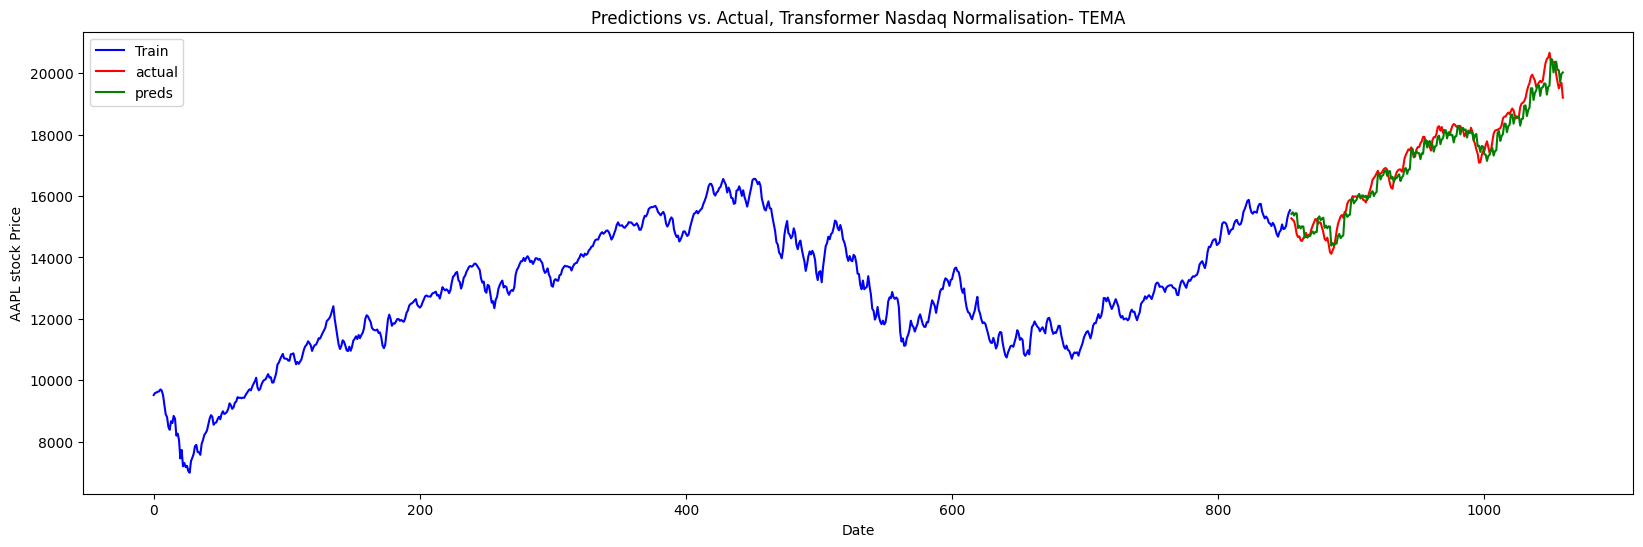

MAPE for TEMA: 0.016504846734787686
RMSE for TEMA: 365.0130649534296
MAE for TEMA: 285.2324647255976
R-squared for TEMA: 0.9517480304163655
(171, 5, 1)
(42, 5, 1)
[[[0.18703794]
  [0.19091216]
  [0.19226728]
  [0.19405407]
  [0.19518057]]

 [[0.19091216]
  [0.19226728]
  [0.19405407]
  [0.19518057]
  [0.19930003]]

 [[0.19226728]
  [0.19405407]
  [0.19518057]
  [0.19930003]
  [0.19770714]]

 ...

 [[0.58353565]
  [0.5727398 ]
  [0.56647847]
  [0.5734377 ]
  [0.57651037]]

 [[0.5727398 ]
  [0.56647847]
  [0.5734377 ]
  [0.57651037]
  [0.5881318 ]]

 [[0.56647847]
  [0.5734377 ]
  [0.57651037]
  [0.5881318 ]
  [0.58101292]]] [[0.19930003 0.19770714 0.18934668 0.16988014 0.14962714]
 [0.19770714 0.18934668 0.16988014 0.14962714 0.14081209]
 [0.18934668 0.16988014 0.14962714 0.14081209 0.11903422]
 ...
 [0.5881318  0.58101292 0.58223185 0.58744033 0.60341647]
 [0.58101292 0.58223185 0.58744033 0.60341647 0.61535717]
 [0.58223185 0.58744033 0.60341647 0.61535717 0.62295595]]
[[[0.61179149]


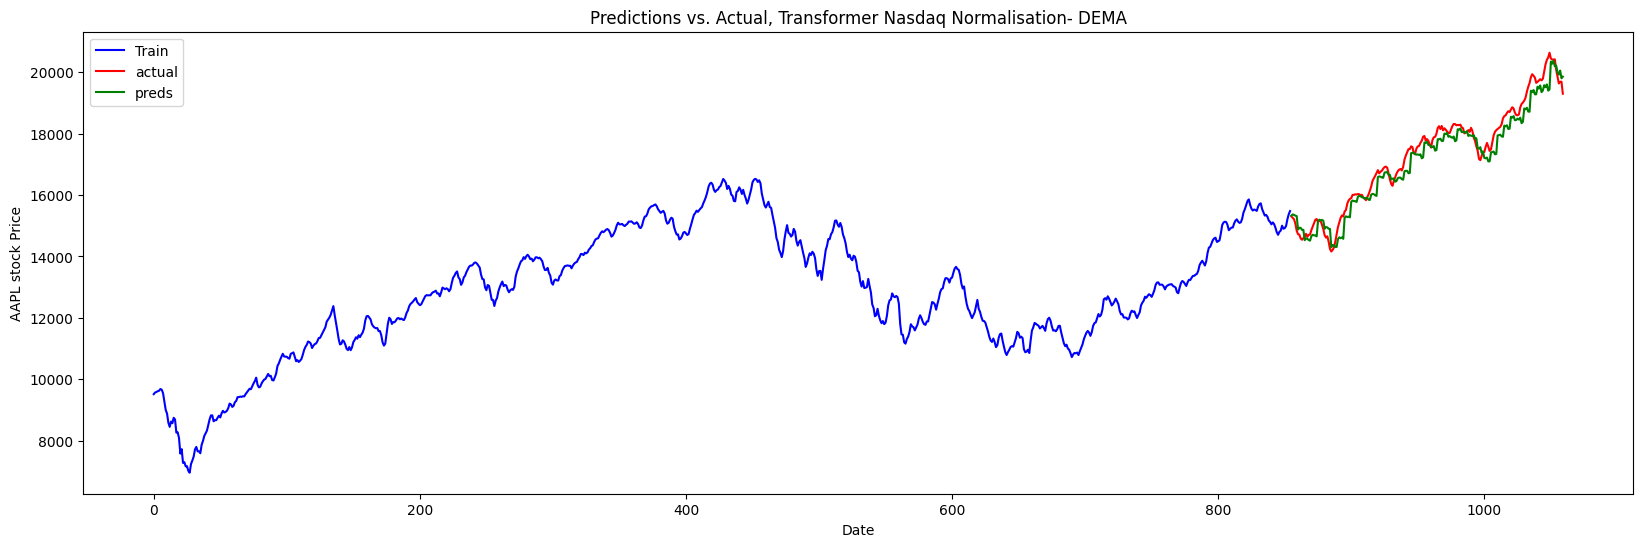

MAPE for DEMA: 0.016872109320267312
RMSE for DEMA: 366.0937951349033
MAE for DEMA: 293.4965706061248
R-squared for DEMA: 0.951639893533539
(170, 5, 1)
(42, 5, 1)
[[[0.18948778]
  [0.18469545]
  [0.17150426]
  [0.15492697]
  [0.14327744]]

 [[0.18469545]
  [0.17150426]
  [0.15492697]
  [0.14327744]
  [0.12495144]]

 [[0.17150426]
  [0.15492697]
  [0.14327744]
  [0.12495144]
  [0.11318478]]

 ...

 [[0.58241614]
  [0.57549605]
  [0.57625856]
  [0.57766977]
  [0.58567633]]

 [[0.57549605]
  [0.57625856]
  [0.57766977]
  [0.58567633]
  [0.58407177]]

 [[0.57625856]
  [0.57766977]
  [0.58567633]
  [0.58407177]
  [0.58508863]]] [[0.12495144 0.11318478 0.1166869  0.11413352 0.12161283]
 [0.11318478 0.1166869  0.11413352 0.12161283 0.12180234]
 [0.1166869  0.11413352 0.12161283 0.12180234 0.10280066]
 ...
 [0.58407177 0.58508863 0.58763035 0.59766638 0.6075122 ]
 [0.58508863 0.58763035 0.59766638 0.6075122  0.61675452]
 [0.58763035 0.59766638 0.6075122  0.61675452 0.62233267]]
[[[0.61439081]
 

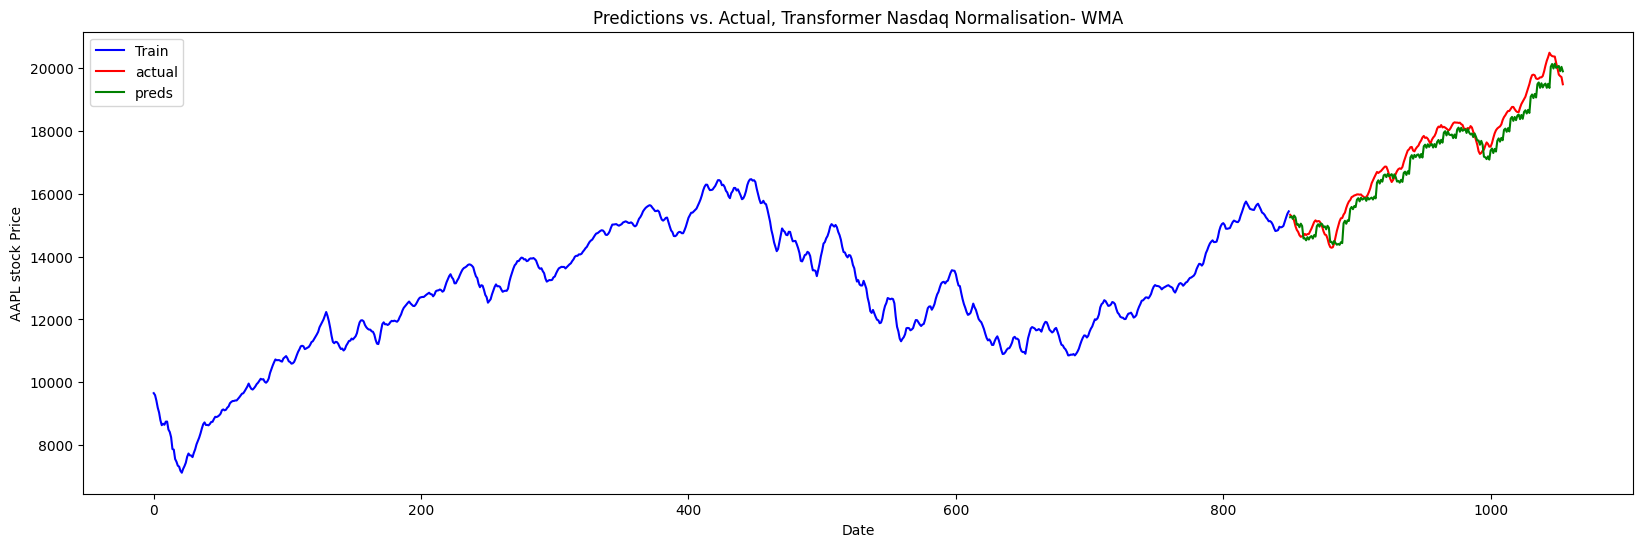

MAPE for WMA: 0.018288097484585798
RMSE for WMA: 378.462561985373
MAE for WMA: 317.76183438740077
R-squared for WMA: 0.9473782493804603
(171, 5, 1)
(42, 5, 1)
[[[0.1768459 ]
  [0.17924804]
  [0.18040855]
  [0.18188467]
  [0.18302546]]

 [[0.17924804]
  [0.18040855]
  [0.18188467]
  [0.18302546]
  [0.18602665]]

 [[0.18040855]
  [0.18188467]
  [0.18302546]
  [0.18602665]
  [0.18573715]]

 ...

 [[0.59468613]
  [0.58637142]
  [0.58029993]
  [0.58234584]
  [0.5830111 ]]

 [[0.58637142]
  [0.58029993]
  [0.58234584]
  [0.5830111 ]
  [0.58947885]]

 [[0.58029993]
  [0.58234584]
  [0.5830111 ]
  [0.58947885]
  [0.58543535]]] [[0.18602665 0.18573715 0.18098023 0.16856065 0.15411406]
 [0.18573715 0.18098023 0.16856065 0.15411406 0.14546285]
 [0.18098023 0.16856065 0.15411406 0.14546285 0.12868265]
 ...
 [0.58947885 0.58543535 0.58589895 0.5889954  0.59922533]
 [0.58543535 0.58589895 0.5889954  0.59922533 0.60820908]
 [0.58589895 0.5889954  0.59922533 0.60820908 0.61517182]]
[[[0.61617628]
  [0

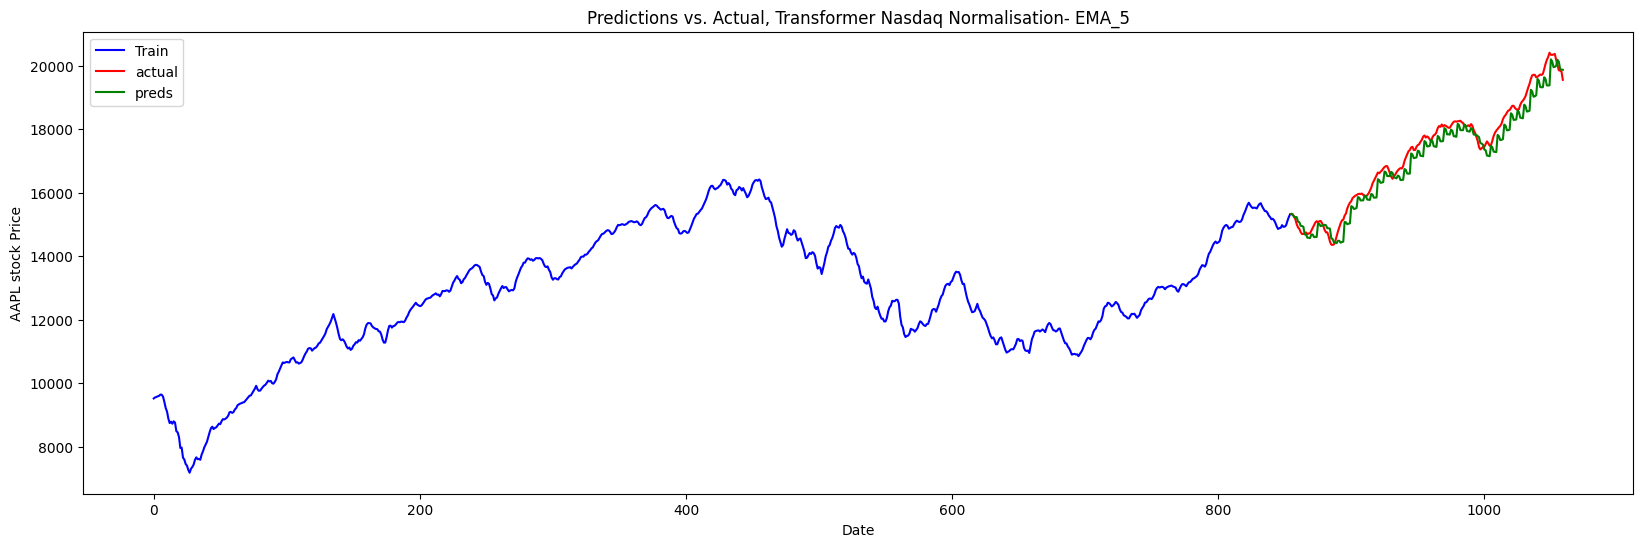

MAPE for EMA_5: 0.016878977199313673
RMSE for EMA_5: 354.80437076646126
MAE for EMA_5: 293.3734232495228
R-squared for EMA_5: 0.9532504723441806
(170, 5, 1)
(42, 5, 1)
[[[0.18505714]
  [0.18280734]
  [0.17459459]
  [0.16259246]
  [0.1498348 ]]

 [[0.18280734]
  [0.17459459]
  [0.16259246]
  [0.1498348 ]
  [0.13185025]]

 [[0.17459459]
  [0.16259246]
  [0.1498348 ]
  [0.13185025]
  [0.11698049]]

 ...

 [[0.58769913]
  [0.5826679 ]
  [0.57860797]
  [0.57666495]
  [0.58076551]]

 [[0.5826679 ]
  [0.57860797]
  [0.57666495]
  [0.58076551]
  [0.58228487]]

 [[0.57860797]
  [0.57666495]
  [0.58076551]
  [0.58228487]
  [0.58601402]]] [[0.13185025 0.11698049 0.11393591 0.11030657 0.11144681]
 [0.11698049 0.11393591 0.11030657 0.11144681 0.11499477]
 [0.11393591 0.11030657 0.11144681 0.11499477 0.10723724]
 ...
 [0.58228487 0.58601402 0.58776195 0.59482178 0.59956825]
 [0.58601402 0.58776195 0.59482178 0.59956825 0.60990503]
 [0.58776195 0.59482178 0.59956825 0.60990503 0.61819448]]
[[[0.61858

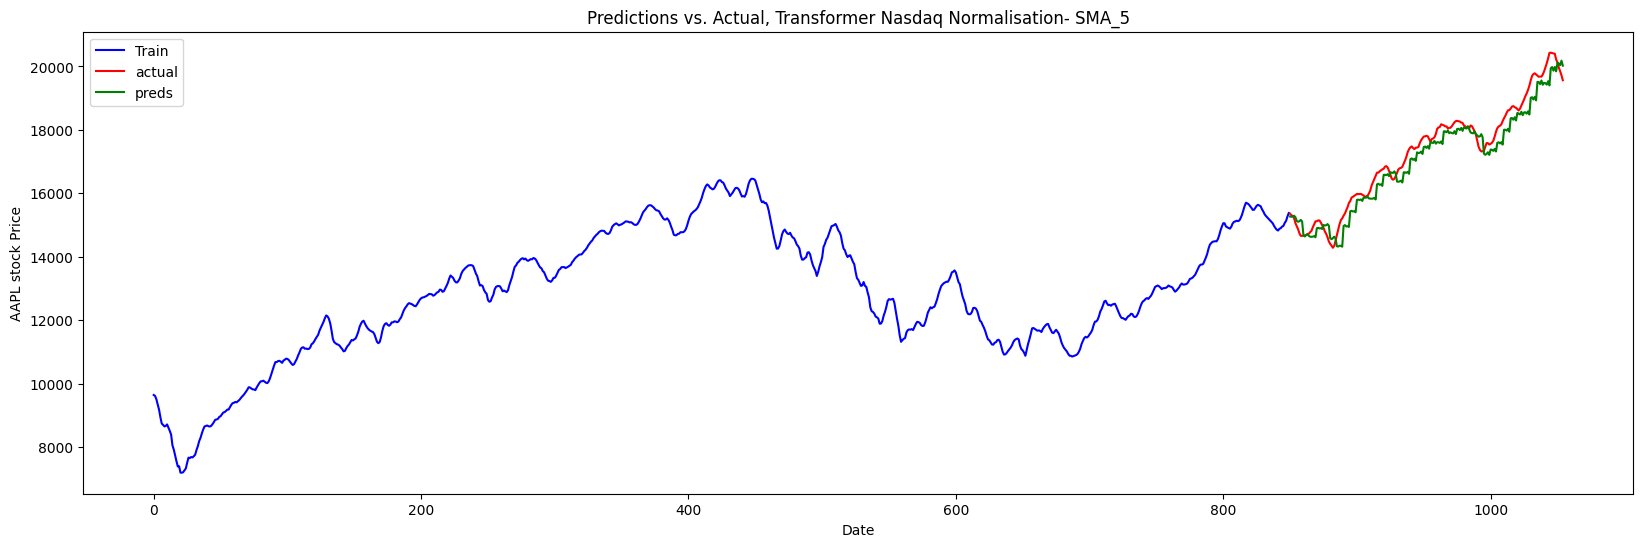

MAPE for SMA_5: 0.01899193854189955
RMSE for SMA_5: 387.8217312689186
MAE for SMA_5: 328.64752883184536
R-squared for SMA_5: 0.9445147486480208
(171, 5, 1)
(42, 5, 1)
[[[0.16024944]
  [0.1616032 ]
  [0.16246234]
  [0.16356115]
  [0.16454849]]

 [[0.1616032 ]
  [0.16246234]
  [0.16356115]
  [0.16454849]
  [0.16661907]]

 [[0.16246234]
  [0.16356115]
  [0.16454849]
  [0.16661907]
  [0.16702245]]

 ...

 [[0.60065594]
  [0.59438959]
  [0.58896481]
  [0.58796048]
  [0.58674501]]

 [[0.59438959]
  [0.58896481]
  [0.58796048]
  [0.58674501]
  [0.58914558]]

 [[0.58896481]
  [0.58796048]
  [0.58674501]
  [0.58914558]
  [0.58640092]]] [[0.16661907 0.16702245 0.16478043 0.15773402 0.14849334]
 [0.16702245 0.16478043 0.15773402 0.14849334 0.141485  ]
 [0.16478043 0.15773402 0.14849334 0.141485   0.1295445 ]
 ...
 [0.58914558 0.58640092 0.58593573 0.587126   0.59270172]
 [0.58640092 0.58593573 0.587126   0.59270172 0.59848311]
 [0.58593573 0.587126   0.59270172 0.59848311 0.60376202]]
[[[0.611612

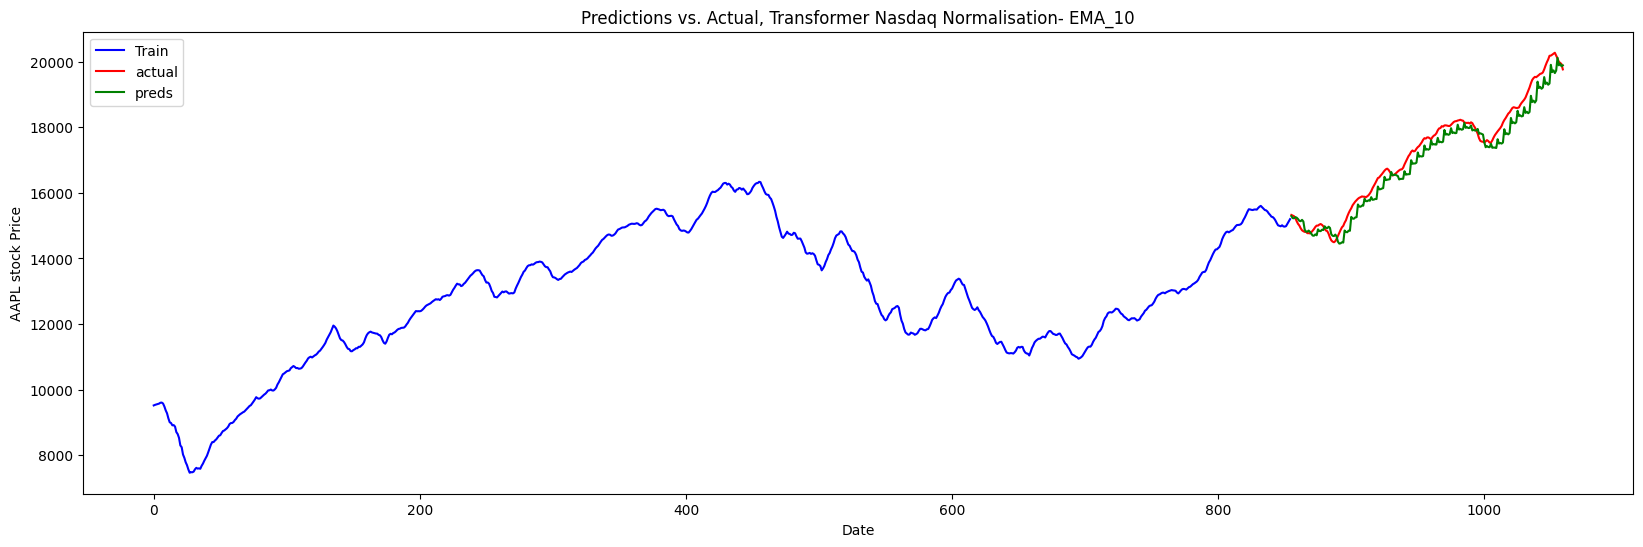

MAPE for EMA_10: 0.01706887312467658
RMSE for EMA_10: 346.3968361837908
MAE for EMA_10: 296.3520813066915
R-squared for EMA_10: 0.9539082891069047
(169, 5, 1)
(42, 5, 1)
[[[0.05422114]
  [0.05587998]
  [0.05507227]
  [0.05657757]
  [0.05650216]]

 [[0.05587998]
  [0.05507227]
  [0.05657757]
  [0.05650216]
  [0.0491833 ]]

 [[0.05507227]
  [0.05657757]
  [0.05650216]
  [0.0491833 ]
  [0.0484878 ]]

 ...

 [[0.58189007]
  [0.58082069]
  [0.57993031]
  [0.57996566]
  [0.57924331]]

 [[0.58082069]
  [0.57993031]
  [0.57996566]
  [0.57924331]
  [0.57913903]]

 [[0.57993031]
  [0.57996566]
  [0.57924331]
  [0.57913903]
  [0.57910606]]] [[0.0491833  0.0484878  0.04633325 0.0365716  0.03599989]
 [0.0484878  0.04633325 0.0365716  0.03599989 0.02998483]
 [0.04633325 0.0365716  0.03599989 0.02998483 0.02639262]
 ...
 [0.57913903 0.57910606 0.57990785 0.58223467 0.58653715]
 [0.57910606 0.57990785 0.58223467 0.58653715 0.59025966]
 [0.57990785 0.58223467 0.58653715 0.59025966 0.59281928]]
[[[0.593

/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_7721/2130994814.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[period-1] = price[period-1]
/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_7721/2130994814.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  kama[i] = kama[i-1] + sc[i] * (price[i] - kama[i-1])


27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - loss: 0.1295 - mae: 0.3053 - mape: 119373.1641 - val_loss: 0.0526 - val_mae: 0.2083 - val_mape: 27.2837
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0084 - mae: 0.0709 - mape: 44728.0547 - val_loss: 0.0044 - val_mae: 0.0515 - val_mape: 6.5678
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0028 - mae: 0.0421 - mape: 83759.9062 - val_loss: 0.0014 - val_mae: 0.0306 - val_mape: 3.9156
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - mae: 0.0330 - mape: 84257.9531 - val_loss: 9.6605e-04 - val_mae: 0.0241 - val_mape: 3.1588
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - mae: 0.0288 - mape: 124196.5703 - val_loss: 5.9798e-04 - val_mae: 0.0178 - val_mape: 2.3711
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0013 - mae: 0.0274 - mape: 12674.6299 - val_loss: 3.9332e-04 - val_mae: 0.0147 - val_mape: 2.0455
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0014 - ma

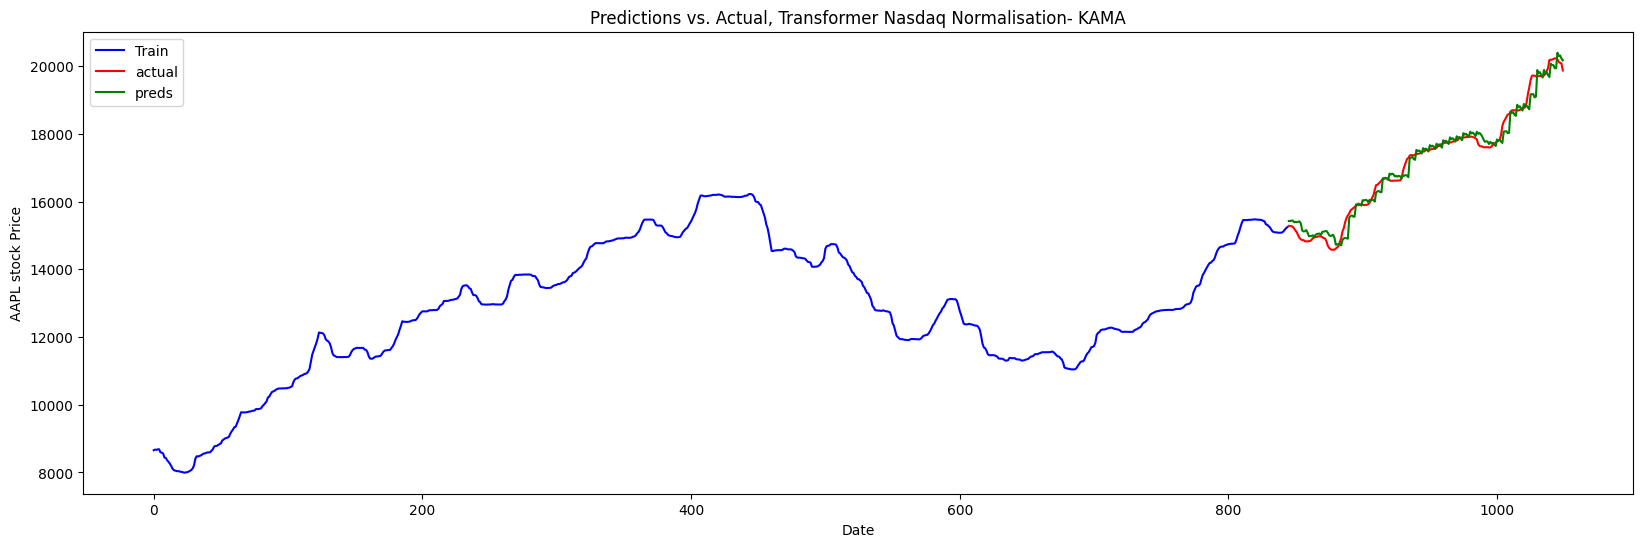

MAPE for KAMA: 0.010152464417826914
RMSE for KAMA: 230.03849630423764
MAE for KAMA: 171.8859968740978
R-squared for KAMA: 0.9794203789759177
(169, 5, 1)
(42, 5, 1)
[[[0.14219483]
  [0.13646146]
  [0.12850032]
  [0.12258355]
  [0.11523097]]

 [[0.13646146]
  [0.12850032]
  [0.12258355]
  [0.11523097]
  [0.10370685]]

 [[0.12850032]
  [0.12258355]
  [0.11523097]
  [0.10370685]
  [0.09826752]]

 ...

 [[0.59385581]
  [0.59023278]
  [0.58743307]
  [0.58778948]
  [0.58538725]]

 [[0.59023278]
  [0.58743307]
  [0.58778948]
  [0.58538725]
  [0.5847241 ]]

 [[0.58743307]
  [0.58778948]
  [0.58538725]
  [0.5847241 ]
  [0.58354659]]] [[0.10370685 0.09826752 0.09189475 0.07951362 0.07611935]
 [0.09826752 0.09189475 0.07951362 0.07611935 0.06503515]
 [0.09189475 0.07951362 0.07611935 0.06503515 0.0542387 ]
 ...
 [0.5847241  0.58354659 0.58615259 0.5906584  0.59669675]
 [0.58354659 0.58615259 0.5906584  0.59669675 0.60281784]
 [0.58615259 0.5906584  0.59669675 0.60281784 0.60721284]]
[[[0.6151849 ]

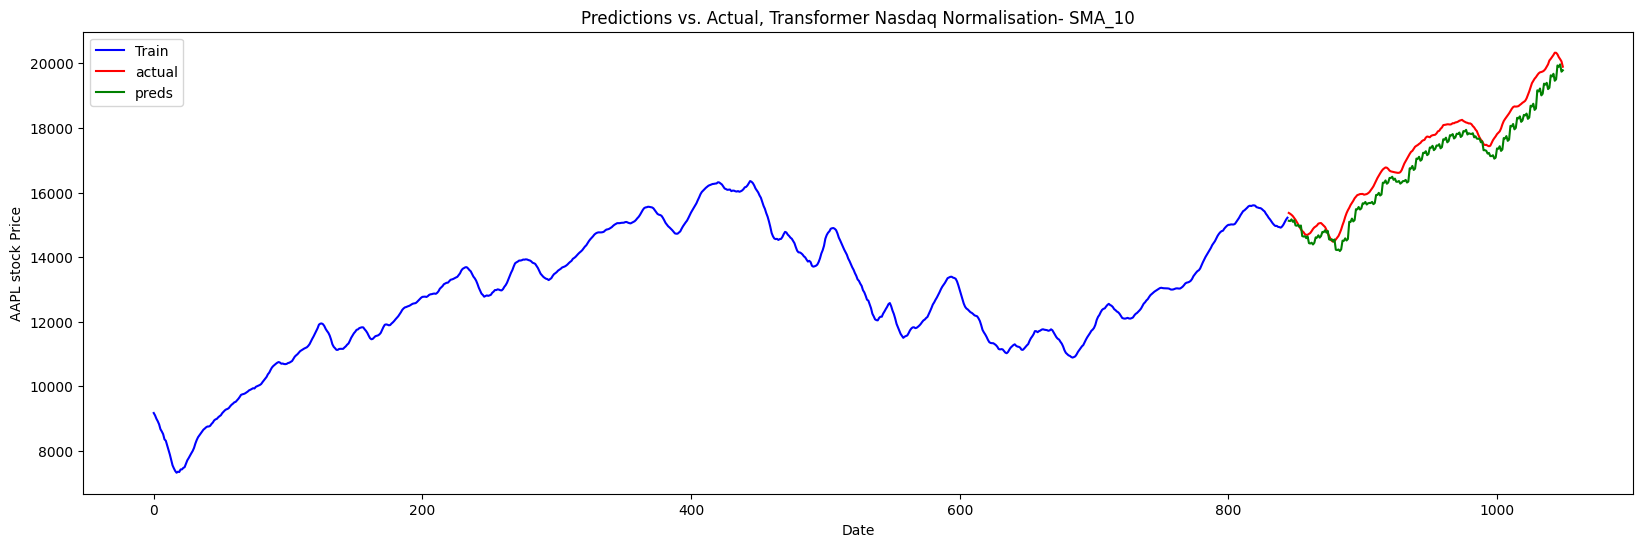

MAPE for SMA_10: 0.024094033553660146
RMSE for SMA_10: 464.6736287879858
MAE for SMA_10: 417.7631459263394
R-squared for SMA_10: 0.9180606518157272
(171, 5, 1)
(42, 5, 1)
[[[0.18571442]
  [0.18668595]
  [0.18741215]
  [0.18837237]
  [0.18932975]]

 [[0.18668595]
  [0.18741215]
  [0.18837237]
  [0.18932975]
  [0.19112732]]

 [[0.18741215]
  [0.18837237]
  [0.18932975]
  [0.19112732]
  [0.19187463]]

 ...

 [[0.60928471]
  [0.60128298]
  [0.59358848]
  [0.58908779]
  [0.58638429]]

 [[0.60128298]
  [0.59358848]
  [0.58908779]
  [0.58638429]
  [0.58639135]]

 [[0.59358848]
  [0.58908779]
  [0.58638429]
  [0.58639135]
  [0.58341924]]] [[0.19112732 0.19187463 0.19072455 0.18591337 0.17893985]
 [0.19187463 0.19072455 0.18591337 0.17893985 0.17284356]
 [0.19072455 0.18591337 0.17893985 0.17284356 0.16271366]
 ...
 [0.58639135 0.58341924 0.58125255 0.58104945 0.58503588]
 [0.58341924 0.58125255 0.58104945 0.58503588 0.58948429]
 [0.58125255 0.58104945 0.58503588 0.58948429 0.5945331 ]]
[[[0.61

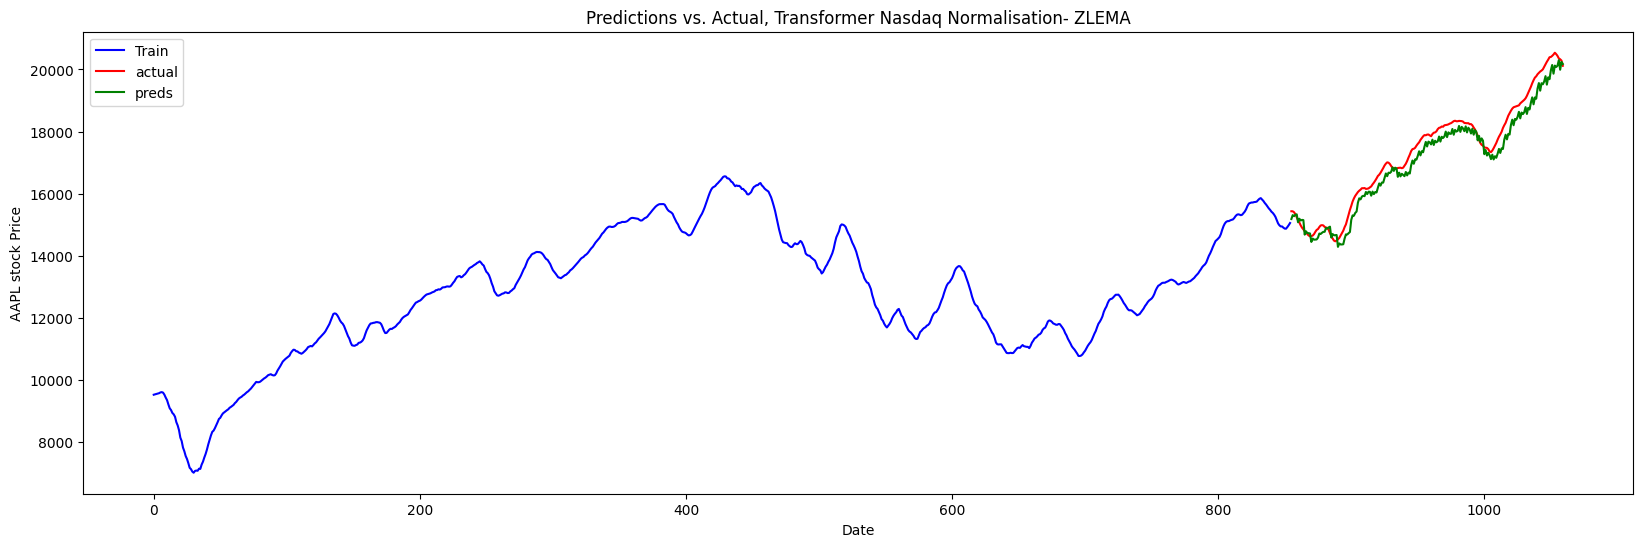

MAPE for ZLEMA: 0.0181344773531583
RMSE for ZLEMA: 359.5951823548112
MAE for ZLEMA: 316.4146297795321
R-squared for ZLEMA: 0.9548223091545777
(166, 5, 1)
(41, 5, 1)
[[[0.03521812]
  [0.02637967]
  [0.02190196]
  [0.01779108]
  [0.01246174]]

 [[0.02637967]
  [0.02190196]
  [0.01779108]
  [0.01246174]
  [0.0156902 ]]

 [[0.02190196]
  [0.01779108]
  [0.01246174]
  [0.0156902 ]
  [0.00781387]]

 ...

 [[0.59192416]
  [0.58791734]
  [0.58666174]
  [0.58881645]
  [0.59073278]]

 [[0.58791734]
  [0.58666174]
  [0.58881645]
  [0.59073278]
  [0.59281721]]

 [[0.58666174]
  [0.58881645]
  [0.59073278]
  [0.59281721]
  [0.59444096]]] [[0.0156902  0.00781387 0.0053202  0.         0.00123941]
 [0.00781387 0.0053202  0.         0.00123941 0.00627988]
 [0.0053202  0.         0.00123941 0.00627988 0.00917356]
 ...
 [0.59281721 0.59444096 0.59850319 0.60252209 0.60597734]
 [0.59444096 0.59850319 0.60252209 0.60597734 0.60808318]
 [0.59850319 0.60252209 0.60597734 0.60808318 0.61147241]]
[[[0.61788113

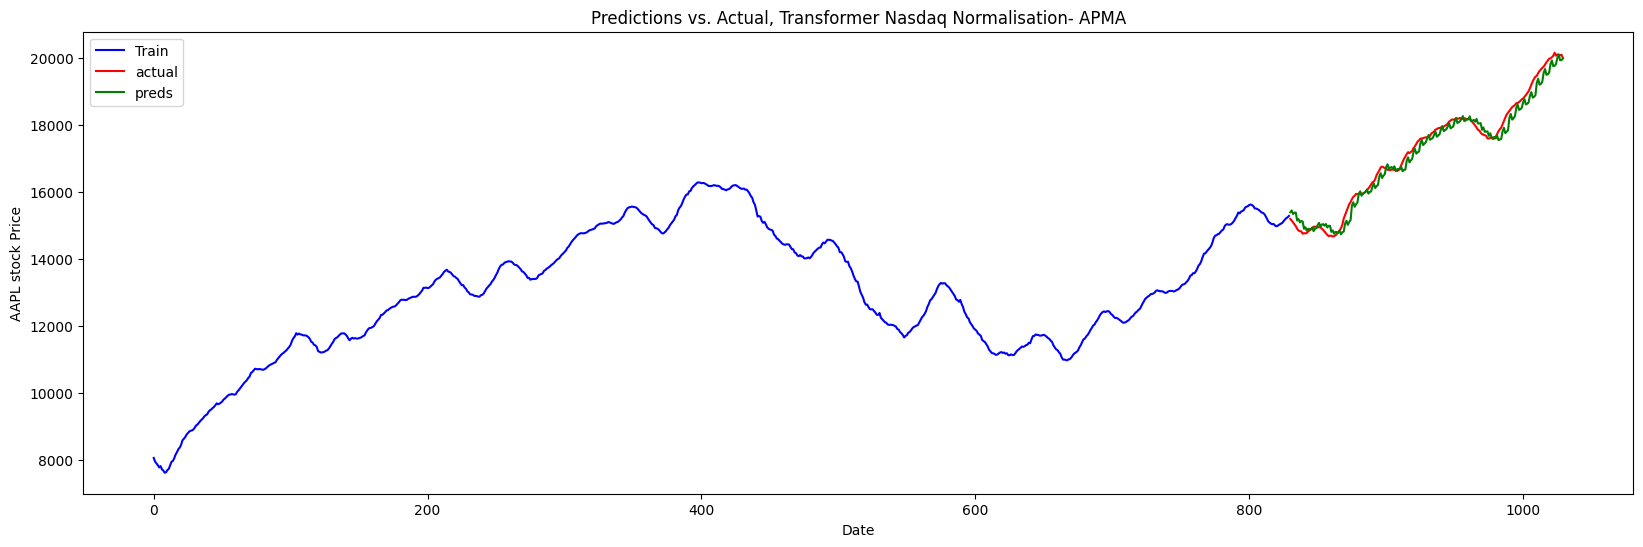

MAPE for APMA: 0.01056604426931979
RMSE for APMA: 224.87682878244726
MAE for APMA: 181.46409299782485
R-squared for APMA: 0.9800573897349162


In [5]:
for j in range(len(list_type_used)):
    try:
        dataset_ma = apply_moving_average(dataset, j)
        dataset_ma.dropna(inplace=True)

        normaliza_bool_update = True
        type_normalisation_update = MinMaxScaler()

        data = ETL(datainput=dataset_ma, test_size=0.2, n_input=5, timestep=5,
                   normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        x_train, y_train = data.X_train, data.y_train
        X_val, y_val = data.X_test, data.y_test
        print(f"Data shapes for {list_type_used[j]}:")
        print(f"X_train shape: {data.X_train.shape}")
        print(f"X_test shape: {data.X_test.shape}")
        print(f"y_train shape: {data.y_train.shape}")
        print(f"y_test shape: {data.y_test.shape}")

        transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4,
                                        mlp_units=[256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)

        hist = fit_transformer(transformer, x_train,
                               y_train, X_val, y_val, display_loss=False)

        transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                               scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

        plot_results(data.train, data.test, transformer_preds.predictions,
                     data.df, normalize_bool=normaliza_bool_update, scaler=type_normalisation_update, title_suffix=f'Transformer Nasdaq Normalisation- {list_type_used[j]}')
        train_evaluation = Evaluate(data.test, transformer_preds.predictions,
                                    normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)
        print(f"MAPE for {list_type_used[j]}: {train_evaluation.mape}")
        print(f"RMSE for {list_type_used[j]}: {train_evaluation.rmse}")
        print(f"MAE for {list_type_used[j]}: {train_evaluation.mae}")
        print(f"R-squared for {list_type_used[j]}: {train_evaluation.r2}")
        tf.keras.backend.clear_session()
    except ValueError as e:
        print(f"Error with {list_type_used[j]}: {e}")

In [ ]:
for i in range(len(list_type_used)):
    print(i)
    print(list_type_used[i])

0
TEMA
1
DEMA
2
WMA
3
EMA_5
4
SMA_5
5
EMA_10
6
KAMA
7
SMA_10
8
ZLEMA
9
APMA


Continue

[*********************100%%**********************]  1 of 1 completed

(1393, 5, 1)
(348, 5, 1)
[[[ 0.33482099]
  [ 0.33593801]
  [ 0.33705401]
  [ 0.339286  ]
  [ 0.33816978]]

 [[ 0.33593801]
  [ 0.33705401]
  [ 0.339286  ]
  [ 0.33816978]
  [ 0.33056096]]

 [[ 0.33705401]
  [ 0.339286  ]
  [ 0.33816978]
  [ 0.33056096]
  [ 0.31598654]]

 ...

 [[37.72177487]
  [37.88002313]
  [38.04518833]
  [38.09745532]
  [38.18331271]]

 [[37.88002313]
  [38.04518833]
  [38.09745532]
  [38.18331271]
  [38.30505028]]

 [[38.04518833]
  [38.09745532]
  [38.18331271]
  [38.30505028]
  [38.44986636]]] [[ 0.33056096  0.31598654  0.31084227  0.30748356  0.30929105]
 [ 0.31598654  0.31084227  0.30748356  0.30929105  0.30193346]
 [ 0.31084227  0.30748356  0.30929105  0.30193346  0.29370491]
 ...
 [38.30505028 38.44986636 38.572903   38.63303427 38.68292326]
 [38.44986636 38.572903   38.63303427 38.68292326 38.7245005 ]
 [38.572903   38.63303427 38.68292326 38.7245005  38.80766128]]
[[[ 38.95171763]
  [ 39.02074969]
  [ 39.11336769]
  [ 39.22530296]
  [ 39.33738734]]

 [[ 39

218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 29.8818 - mae: 2.1308 - mape: 76.4071 - val_loss: 5.3260 - val_mae: 1.7179 - val_mape: 1.5352
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8227 - mae: 0.4070 - mape: 8.1290 - val_loss: 20.6998 - val_mae: 3.4905 - val_mape: 3.1114
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.6896 - mae: 0.3812 - mape: 9.4385 - val_loss: 5.1491 - val_mae: 1.5974 - val_mape: 1.4101
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4742 - mae: 0.3250 - mape: 9.2494 - val_loss: 4.5503 - val_mae: 1.5820 - val_mape: 1.4212
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4258 - mae: 0.3092 - mape: 9.9776 - val_loss: 6.4853 - val_mae: 1.9013 - val_mape: 1.7088
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3751 - mae: 0.2949 - mape: 9.6494 - val_loss: 6.0821 - val_mae: 1.9092 - val_mape: 1.7439
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.3237 - mae: 0.2769 - mape: 8.7966

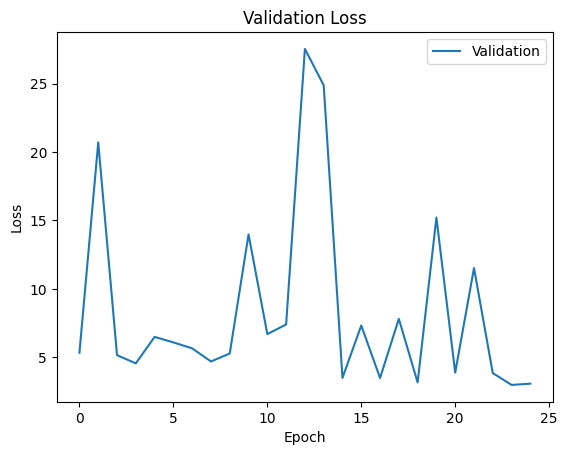

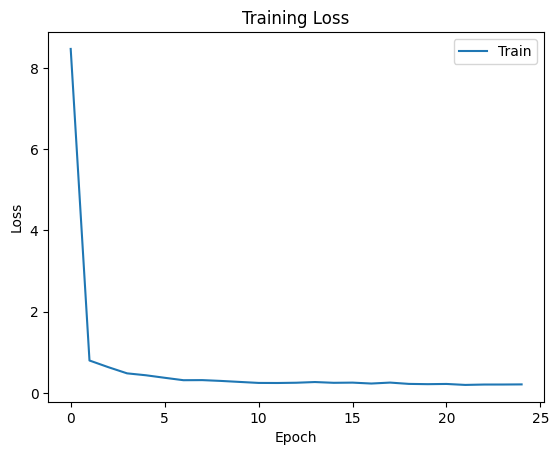

Minimum validation loss: 2.9734


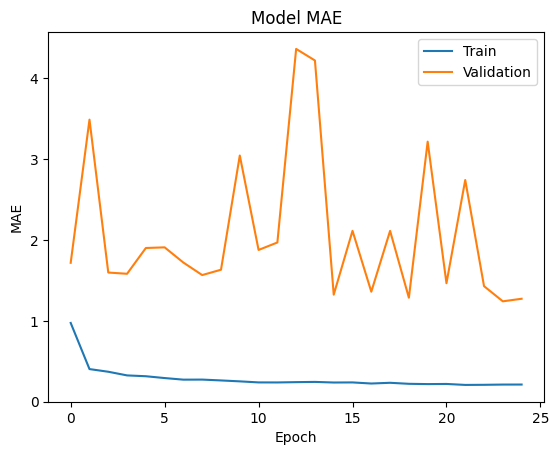

Minimum validation MAE: 1.2411
Minimum validation MAPE: 1.1082
plot_train shape: (6965, 1)
plot_test shape: (1735, 1)
plot_preds shape: (1735, 1)


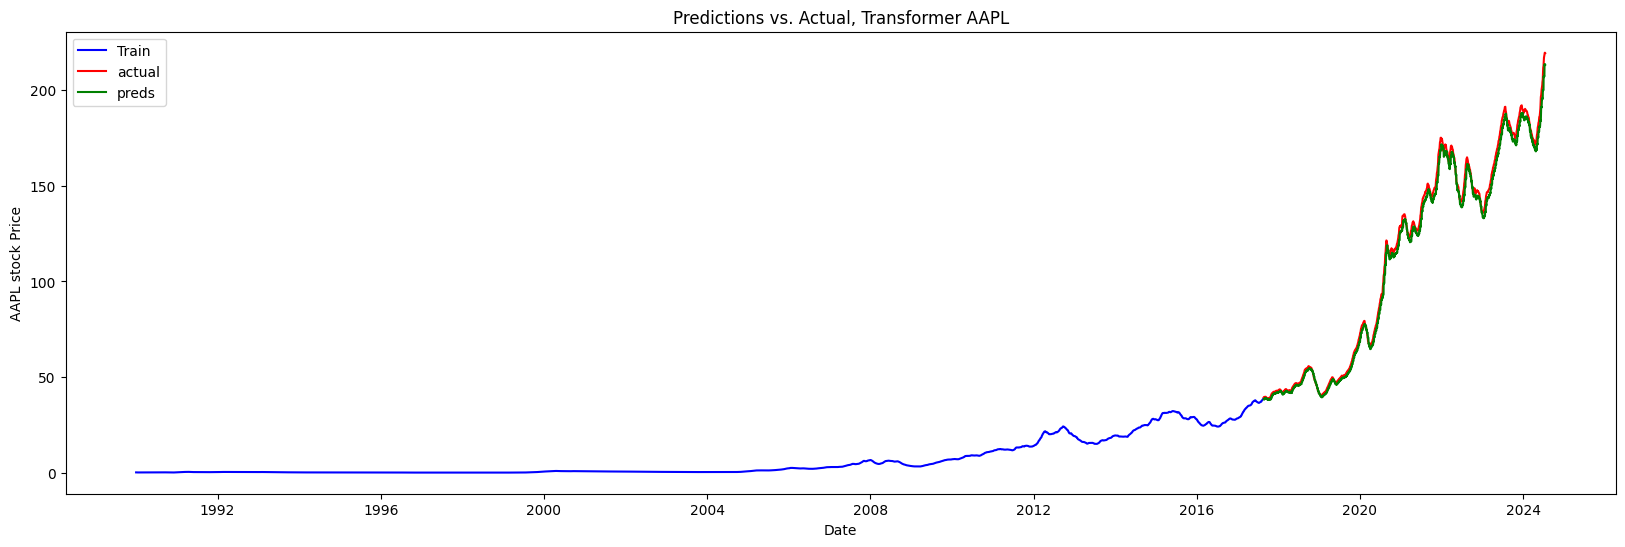

MAPE: 0.02484623522986704
RMSE: 3.3929870169288816
MAE: 2.7394468374235337
R-squared: 0.996110515790853


In [ ]:
# ticker = 'NDX'
ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset['VIDYA'] = calculate_VIDYA(dataset['Close'].tolist(), 14)

normaliza_bool_update = False
type_normalisation_update = None

data = ETL(datainput=dataset['VIDYA'].dropna(), test_size=0.2, n_input=5, timestep=5,
           normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
                                256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
# transformer.summary()
# train the model
# hist = fit_transformer(transformer)
hist = fit_transformer(transformer, data.X_train,
                       data.y_train, data.X_test, data.y_test, display_loss=True)
# time used

transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                       scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data.train, data.test, transformer_preds.predictions,
             data.df, title_suffix='Transformer AAPL')
train_evaluation = Evaluate(data.test, transformer_preds.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

In [ ]:
# ticker = 'NDX'
ticker = 'AAPL'
# timeframe days
dataset = yf.download(ticker, start='1990-01-01',
                      end=datetime.now().strftime('%Y-%m-%d'), interval='1d')
dataset['FRAMA'] = calculate_FRAMA(dataset)

normaliza_bool_update = False
type_normalisation_update = None

data = ETL(datainput=dataset['FRAMA'].dropna(), test_size=0.2, n_input=5, timestep=5,
           normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
                                256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
# transformer.summary()
# train the model
# hist = fit_transformer(transformer)
hist = fit_transformer(transformer, data.X_train,
                       data.y_train, data.X_test, data.y_test, display_loss=True)
# time used

transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                       scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data.train, data.test, transformer_preds.predictions,
             data.df, title_suffix='Transformer AAPL')
train_evaluation = Evaluate(data.test, transformer_preds.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

[*********************100%%**********************]  1 of 1 completed


ValueError: Columns must be same length as key

(1393, 5, 1)
(348, 5, 1)
[[[ 0.333333  ]
  [ 0.33420133]
  [ 0.33515223]
  [ 0.33653015]
  [ 0.33633277]]

 [[ 0.33420133]
  [ 0.33515223]
  [ 0.33653015]
  [ 0.33633277]
  [ 0.33136485]]

 [[ 0.33515223]
  [ 0.33653015]
  [ 0.33633277]
  [ 0.33136485]
  [ 0.32358857]]

 ...

 [[38.97763242]
  [39.32508843]
  [39.63839208]
  [39.36892867]
  [39.36928542]]

 [[39.32508843]
  [39.63839208]
  [39.36892867]
  [39.36928542]
  [39.56702412]]

 [[39.63839208]
  [39.36892867]
  [39.36928542]
  [39.56702412]
  [39.84468326]]] [[ 0.33136485  0.32358857  0.31840438  0.31420426  0.31326417]
 [ 0.32358857  0.31840438  0.31420426  0.31326417  0.30780111]
 [ 0.31840438  0.31420426  0.31326417  0.30780111  0.30155508]
 ...
 [39.56702412 39.84468326 39.97562192 39.80541466 39.66194311]
 [39.84468326 39.97562192 39.80541466 39.66194311 39.5421293 ]
 [39.97562192 39.80541466 39.66194311 39.5421293  39.67641943]]
[[[ 39.79424209]
  [ 39.85116144]
  [ 40.0232744 ]
  [ 40.25801657]
  [ 40.45117822]]

 [[ 39

/var/folders/jb/ggq229g94ql147w8sftb9qs80000gn/T/ipykernel_5726/582874411.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['EMA'] = dataset['Close'].ewm(span=5, adjust=False).mean()


218/218 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 28.8121 - mae: 2.2147 - mape: 105.8289 - val_loss: 13.9796 - val_mae: 2.7116 - val_mape: 2.4240
Epoch 2/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.8775 - mae: 0.4264 - mape: 8.8908 - val_loss: 12.5010 - val_mae: 2.5733 - val_mape: 2.3084
Epoch 3/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.7152 - mae: 0.3892 - mape: 9.9354 - val_loss: 14.8110 - val_mae: 2.8250 - val_mape: 2.5129
Epoch 4/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5643 - mae: 0.3582 - mape: 10.0195 - val_loss: 15.0871 - val_mae: 2.9052 - val_mape: 2.6150
Epoch 5/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.5108 - mae: 0.3450 - mape: 10.4740 - val_loss: 17.8491 - val_mae: 3.1557 - val_mape: 2.8316
Epoch 6/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4429 - mae: 0.3213 - mape: 9.1877 - val_loss: 11.5403 - val_mae: 2.4277 - val_mape: 2.1570
Epoch 7/25
218/218 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.4122 - mae: 0.3053 - mape:

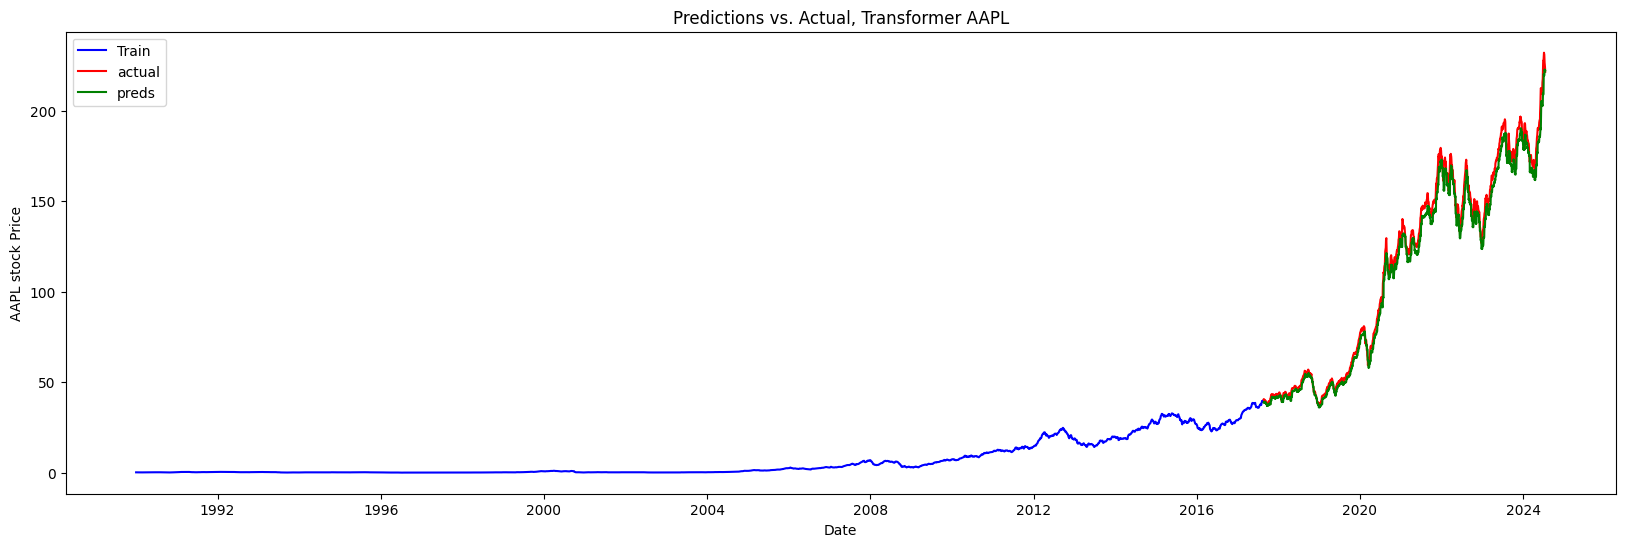

MAPE: 0.039027959181991215
RMSE: 5.4699666214447555
MAE: 4.404864689665083
R-squared: 0.9900905342629601


In [ ]:
dataset['EMA'] = dataset['Close'].ewm(span=5, adjust=False).mean()

normaliza_bool_update = False
type_normalisation_update = None

data = ETL(datainput=dataset['EMA'].dropna(), test_size=0.2, n_input=5, timestep=5,
           normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
                                256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
# transformer.summary()
# train the model
# hist = fit_transformer(transformer)
fit_transformer(transformer, data.X_train,
                data.y_train, data.X_test, data.y_test, display_loss=False)
# time used

transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                       scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data.train, data.test, transformer_preds.predictions,
             data.df, title_suffix='Transformer AAPL')
train_evaluation = Evaluate(data.test, transformer_preds.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")

(1392, 5, 1)
(348, 5, 1)
[[[ 0.33192008]
  [ 0.32328907]
  [ 0.3165182 ]
  [ 0.31093787]
  [ 0.30944967]]

 [[ 0.32328907]
  [ 0.3165182 ]
  [ 0.31093787]
  [ 0.30944967]
  [ 0.30476207]]

 [[ 0.3165182 ]
  [ 0.31093787]
  [ 0.30944967]
  [ 0.30476207]
  [ 0.2991074 ]]

 ...

 [[39.17750015]
  [39.55150019]
  [39.8399999 ]
  [39.58483378]
  [39.51383336]]

 [[39.55150019]
  [39.8399999 ]
  [39.58483378]
  [39.51383336]
  [39.62216721]]

 [[39.8399999 ]
  [39.58483378]
  [39.51383336]
  [39.62216721]
  [39.85900091]]] [[ 0.30476207  0.2991074   0.30029794  0.29866094  0.2991072 ]
 [ 0.2991074   0.30029794  0.29866094  0.2991072   0.30096713]
 [ 0.30029794  0.29866094  0.2991072   0.30096713  0.302753  ]
 ...
 [39.62216721 39.85900091 40.01633377 39.91800028 39.74733353]
 [39.85900091 40.01633377 39.91800028 39.74733353 39.55216726]
 [40.01633377 39.91800028 39.74733353 39.55216726 39.61516698]]
[[[ 39.7921669 ]
  [ 39.88483353]
  [ 40.07233353]
  [ 40.30883382]
  [ 40.52983424]]

 [[ 39

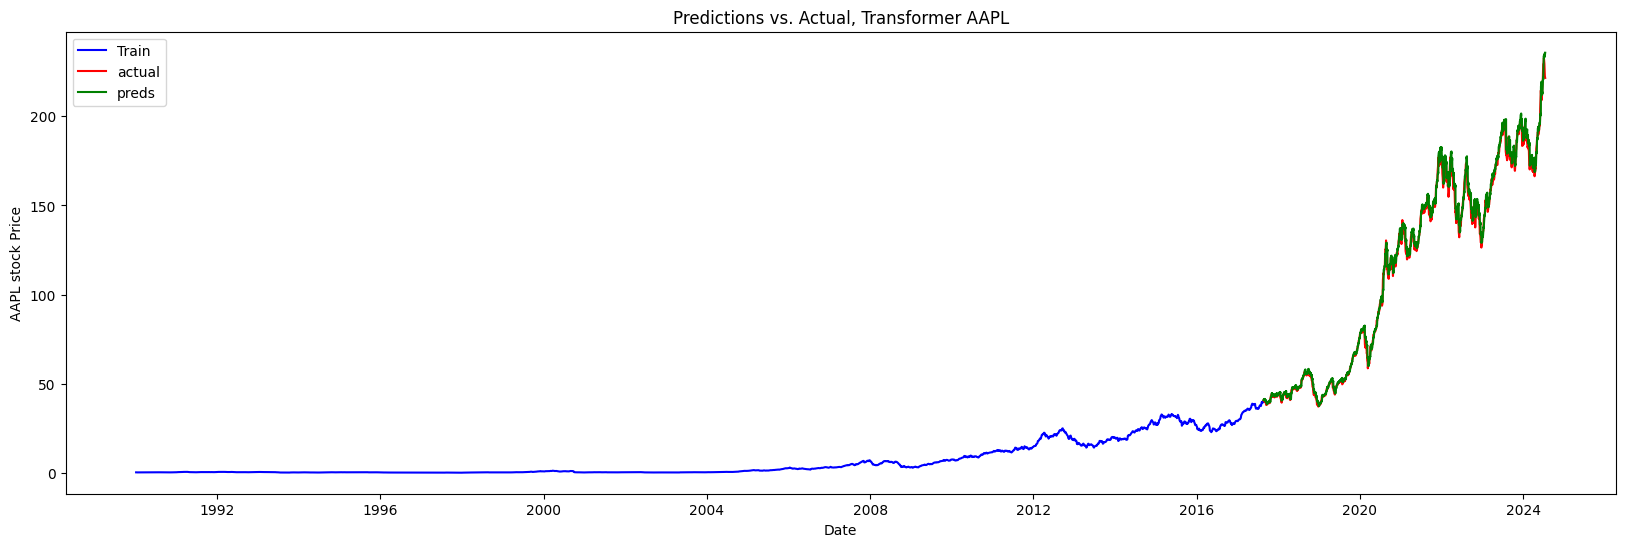

MAPE: 0.021682739763214942
RMSE: 3.5901572644736524
MAE: 2.459456583951168
R-squared: 0.995738632656337


In [ ]:
weights = np.arange(1, period + 1)
dataset['WMA'] = dataset['Close'].rolling(window=period).apply(
    lambda prices: np.dot(prices, weights)/weights.sum(), raw=True)

normaliza_bool_update = False
type_normalisation_update = None

data = ETL(datainput=dataset['WMA'].dropna(), test_size=0.2, n_input=5, timestep=5,
           normalize_bool=normaliza_bool_update, scaler=type_normalisation_update)

transformer = build_transfromer(head_size=128, num_heads=4, ff_dim=2, num_trans_blocks=4, mlp_units=[
                                256], mlp_dropout=0.10, dropout=0.10, attention_axes=1)
# transformer.summary()
# train the model
# hist = fit_transformer(transformer)
hist = fit_transformer(transformer, data.X_train,
                       data.y_train, data.X_test, data.y_test, display_loss=False)
# time used

transformer_preds = PredictAndForecast(transformer, data.train, data.test, n_input=5,
                                       scaler=type_normalisation_update, normalize_bool=normaliza_bool_update)

plot_results(data.train, data.test, transformer_preds.predictions,
             data.df, title_suffix='Transformer AAPL')
train_evaluation = Evaluate(data.test, transformer_preds.predictions)
print(f"MAPE: {train_evaluation.mape}")
print(f"RMSE: {train_evaluation.rmse}")
print(f"MAE: {train_evaluation.mae}")
print(f"R-squared: {train_evaluation.r2}")